In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from igraph import *
from scipy import stats
from collections import defaultdict
from analise_breakpoints import read_file_original

In [2]:
def read_file(samples_breakpoints='data/breakpoints_k4it.max100stop.if.errorFALSE.txt'):
    samples_breakpoints = open(samples_breakpoints,'r').read().split('\n')[:-1]
    total_series = len(samples_breakpoints)
    slopes = []
    breakpoints = []
    preds = []
    idxs = []
    for i in range(0,total_series,4):
        idx = int(samples_breakpoints[i]) - 1
        
        slopes_i = [float(n) for n in samples_breakpoints[i+1].split(' ')]
        breakpoints_i = [float(n) for n in samples_breakpoints[i+2].split(' ')]
        preds_i = [float(n) for n in samples_breakpoints[i+3].split(' ')]
        idxs.append(idx)
        slopes.append(np.asarray(slopes_i))
        breakpoints.append(np.asarray(breakpoints_i))
        preds.append(np.asarray(preds_i))
    
    return np.asarray(idxs),np.asarray(slopes),np.asarray(breakpoints),np.asarray(preds)

In [3]:
def plot_hist(visualizations,filename):
    n, bins, patches = plt.hist(visualizations, 20, density=True, facecolor='g', alpha=0.75)
    plt.yscale('log')
    plt.savefig(filename)
    plt.cla()

# return indexes
def group_by_num_vis(ys,k1,k2):
    groups = defaultdict(lambda:[])
    deleted = []
    for i,y in ys.items():
        if y > k1:
            if y < k2:
                groups[1].append(i)
            else:
                groups[2].append(i)
        else:
            deleted.append(i)
    return groups,deleted

def deleted_hist():
    deleted_delta_time = []
    for d in deleted:
        x = xs[d]
        delta = x[-1]-x[0]
        deleted_delta_time.append(delta)
    plot_hist(deleted_delta_time,'hist_deleted_articles.png')

In [4]:
def breakpoints_hist():
    idxs = idxs.tolist()

    for k,v in groups.items():
        ys_v = visualizations[v]
        print(k,len(ys_v),min(ys_v),max(ys_v),np.std(ys_v))
        plot_hist(ys_v,'hist_group_'+str(k)+'.png')

        breakpoints_freq = []
        # print(v[:10])
        # print(idxs[:10])
        for i in v:
            try:
                i = idxs.index(i)
                breakpoints_freq.append(len(breakpoints[i]))
            except:
                pass
        plot_hist(breakpoints_freq,'hist_breakpoints_freq_'+str(k)+'.png')

def brusque_changes(slopes,n):
    diffs = []
    idxs = []
    for i,seq_slopes in slopes.items():
        last = seq_slopes[0]
        for slope in seq_slopes[1:]:
            diff = slope - last
            last = slope
            diffs.append(diff)
            idxs.append(i)
    ranking = np.argsort(diffs)
    topN = ranking[:n].tolist() + ranking[-n:].tolist()
    idxs = np.asarray(idxs)
    idxs = idxs[topN]
    return idxs

def calculate_ys(xs,slopes,breakpoints):
    bs = breakpoints.tolist() + [1]
    intercept_x = 0
    intercept_y = 0
    i = 0
    y = 0
    ys = []
    print(bs,slopes)
    for j,x in enumerate(xs):

        if x - bs[i] >= 0.001 and x != 1:
            i += 1

        y = (x-intercept_x)*slopes[i] + intercept_y
        print(y,'=',x,'-',intercept_x,'*',slopes[i],'+',intercept_y)
        ys.append(y)
        
        intercept_x = x
        intercept_y = y

    return ys

def plot(xs,ys,color):
    plt.scatter(xs,ys,color=color)
    
def norm(x):
    return (x-min(x))/(max(x)-min(x))

In [5]:
# filename = 'wosPlosOne2016_cocitation.xnet'
# with open(filename) as fp:  
#     line = fp.readline()
#     cnt = 1
#     while line:
#         print("Line {}: {}".format(cnt, line.strip()))
#         line = fp.readline()
#         cnt += 1
#         if cnt == 30:
#             break

In [6]:
json_file = "PlosOneData/wosPlosOne2016_citations.json"


In [23]:
xs,ys = read_file_original(filename='data/plos_one_data_total.txt')
idxs,slopes,breakpoints,preds = read_file('data/plos_one_total_breakpoints_k4it.max100stop.if.errorFALSE_original_data_filtered.txt')
idxs = idxs.tolist()
# slopes = np.asarray([(np.arctan(s)*57.2958) for s in slopes])

In [24]:
data = dict()
for i,s,b,p in zip(idxs,slopes,breakpoints,preds):
    data[i] = (s,b,xs[i],ys[i],p)

In [25]:
visualizations = dict()
for k,sample in data.items():
    visualizations[k] = sample[-2][-1]

In [26]:
groups,deleted = group_by_num_vis(visualizations,1000,5000)

In [27]:
for k,v in groups.items():
    print(len(v))

17870
100099


In [28]:
def get_value(data,idx,valid_idxs):
    values = dict()
    for k in valid_idxs:
        values[k] = data[k][idx]
    return values

def get_by_intervals(data,idxs):
    values = defaultdict(lambda:[])
    for k in idxs:
        sample = data[k]
        number_of_intervals = len(sample[0])
        values[number_of_intervals].append(k)
    return values

def get_values_window(xs,ys,x0,delta):
    values = []
    for x,y in zip(xs,ys):
        if x < x0+delta and x > x0-delta:
            values.append(y)
    return np.asarray(values)

def get_values_points(xs,ys,x0,num_points):
    n = len(xs)
    pos = -1
    for i in range(n-1):
        if xs[i] <= x0 and xs[i+1] > x0:
            pos = i
            break
    values = ys[max(0,pos-num_points):min(pos+num_points,n-1)]
    if pos-num_points < 0:
#         print('antes',values,pos,num_points)
        values = np.concatenate([np.zeros(abs(pos-num_points)),values])
#         print(values)
    if pos+num_points > n-1:
#         print('antes',values,pos,num_points)
        values = np.concatenate([values,np.zeros(abs(pos+num_points-n-1))])
#         print(values)
#     if len(values) != 6:
#         print(values,pos,num_points,n)
    return values

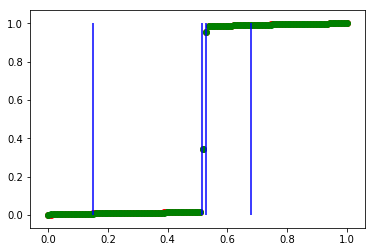

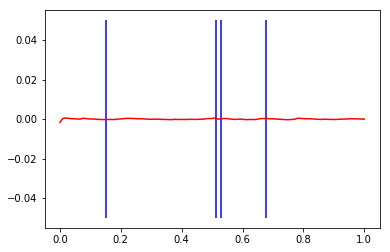

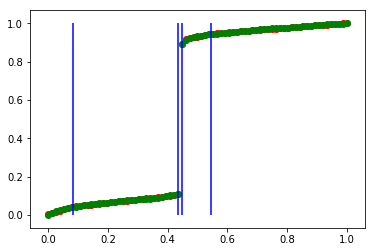

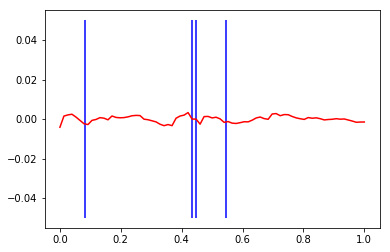

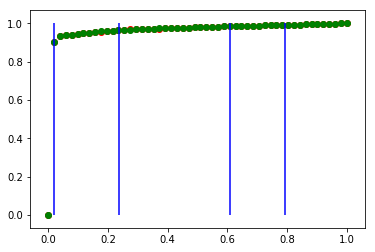

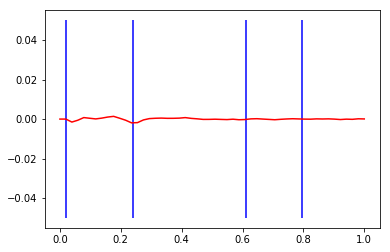

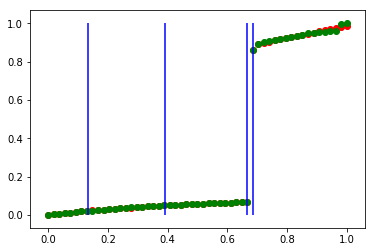

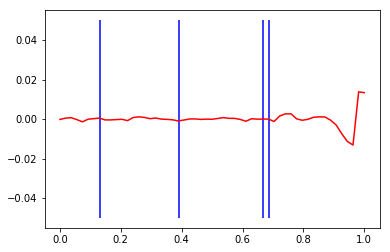

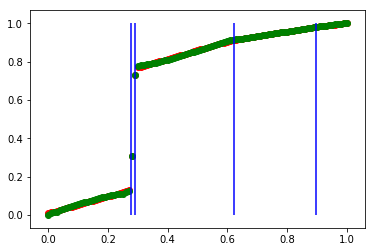

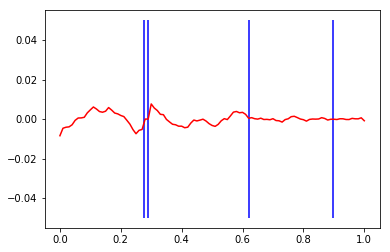

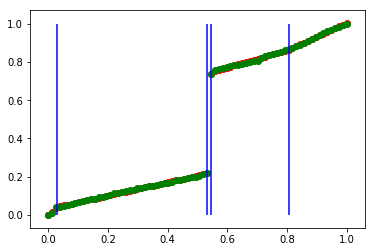

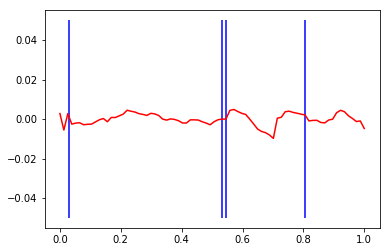

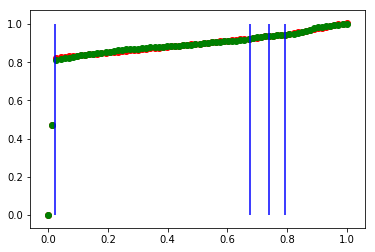

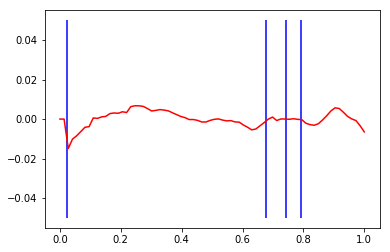

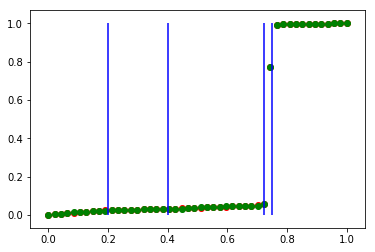

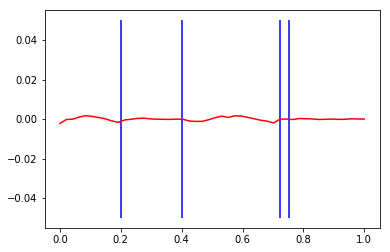

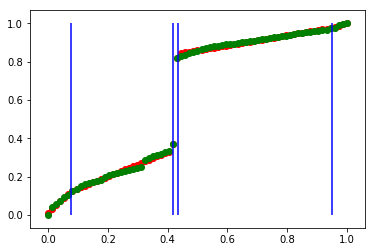

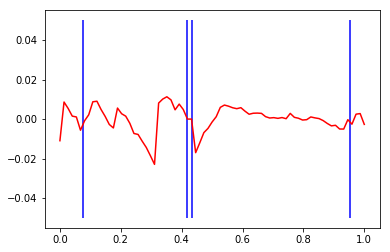

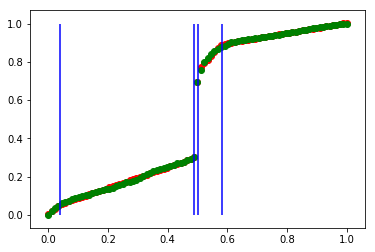

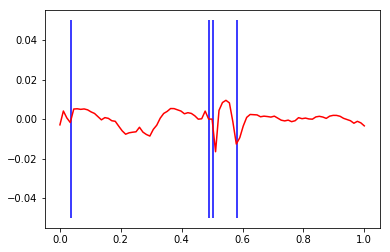

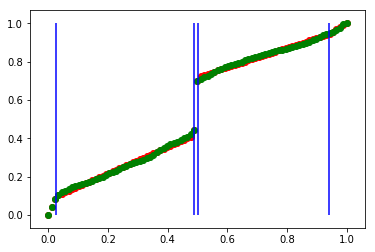

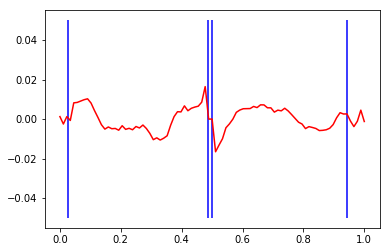

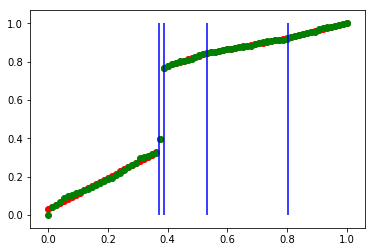

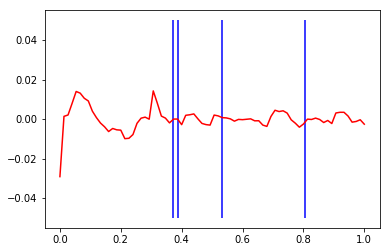

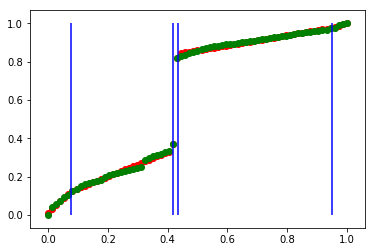

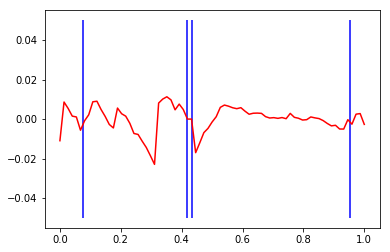

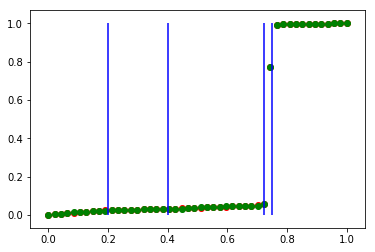

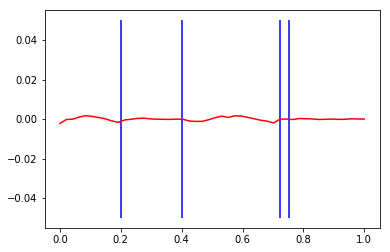

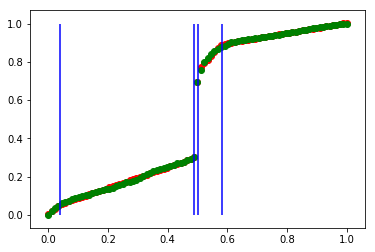

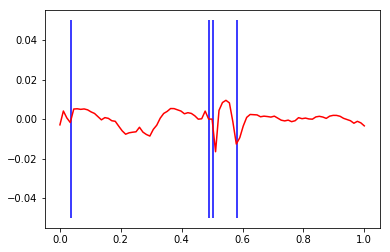

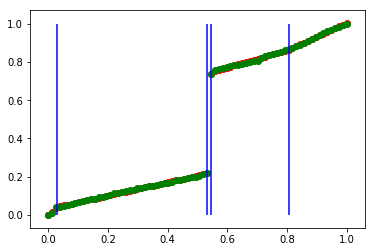

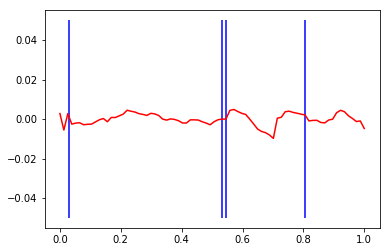

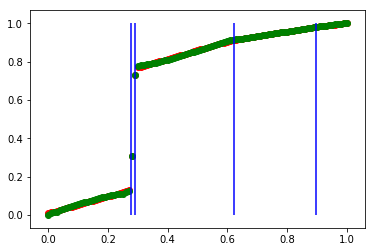

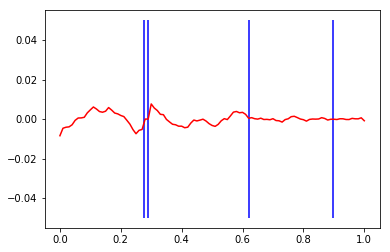

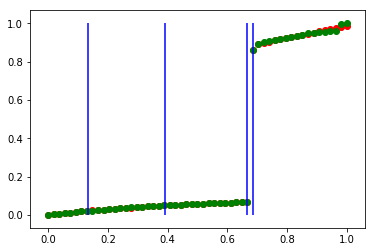

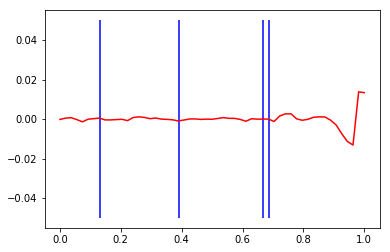

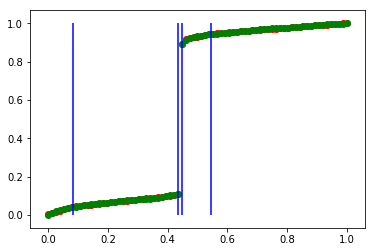

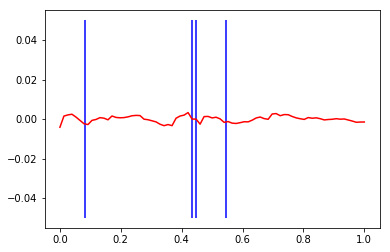

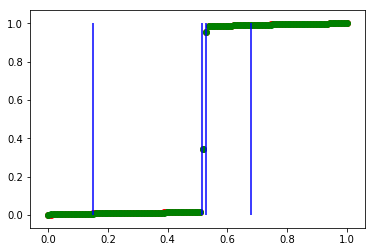

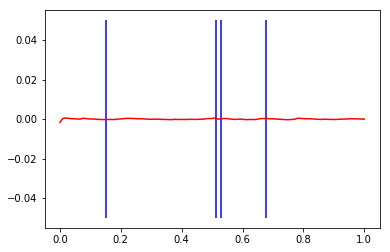

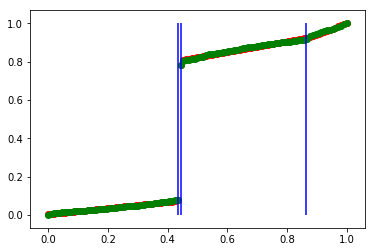

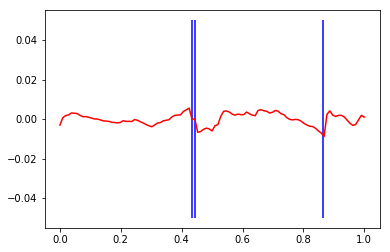

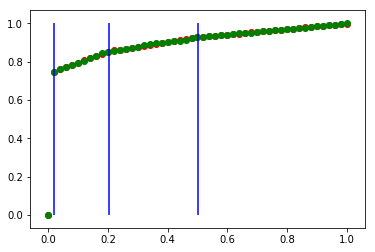

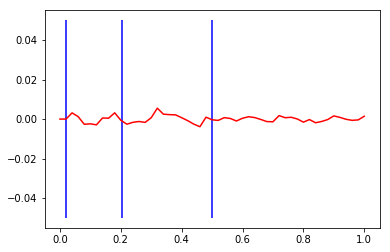

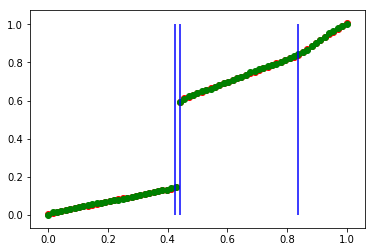

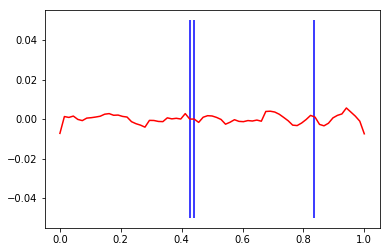

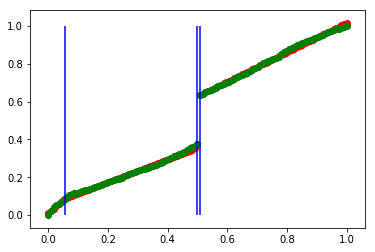

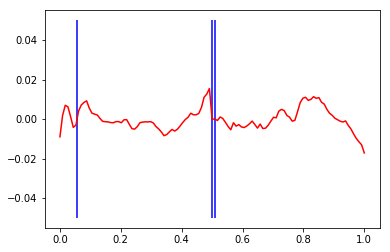

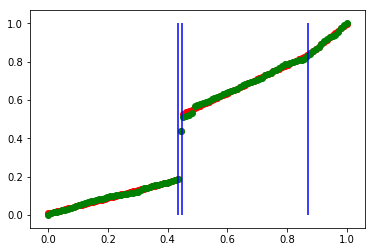

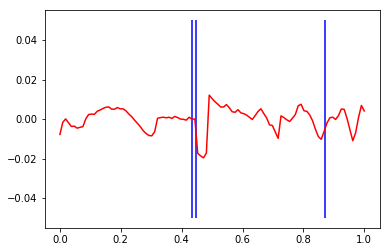

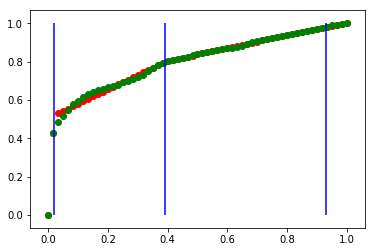

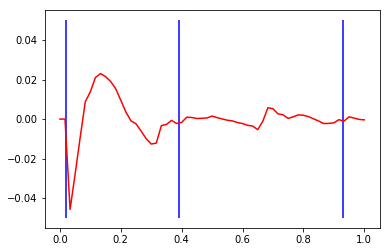

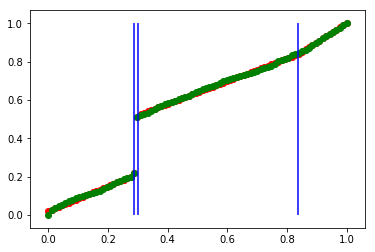

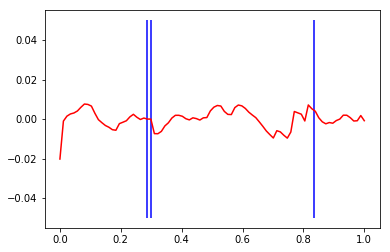

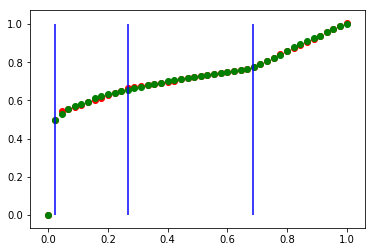

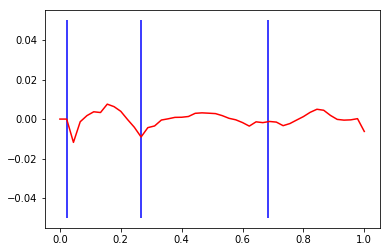

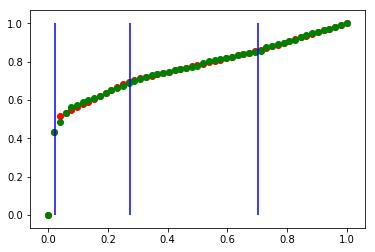

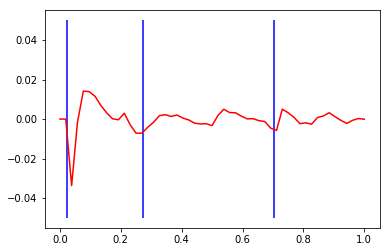

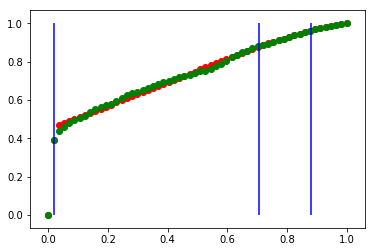

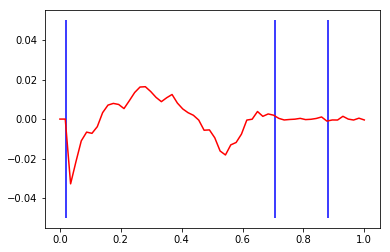

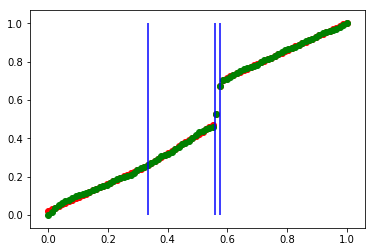

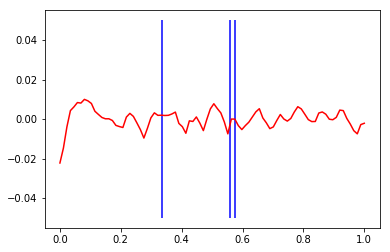

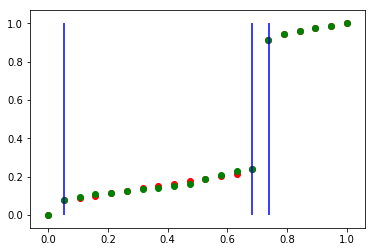

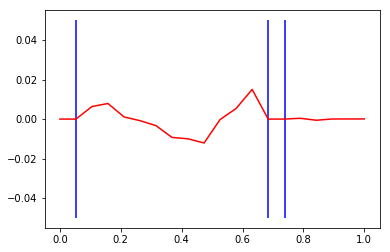

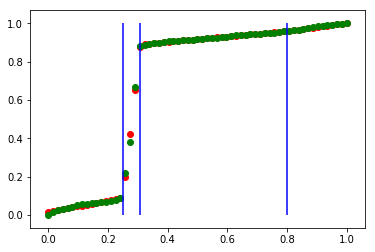

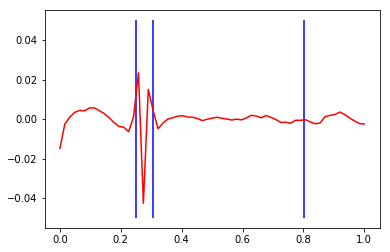

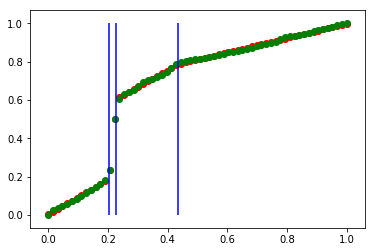

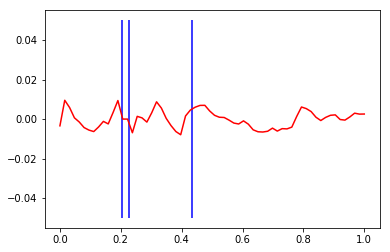

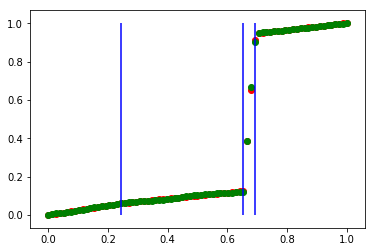

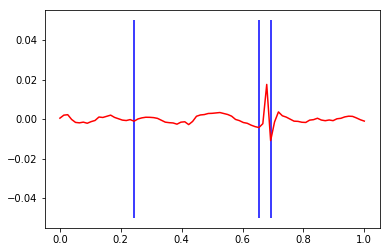

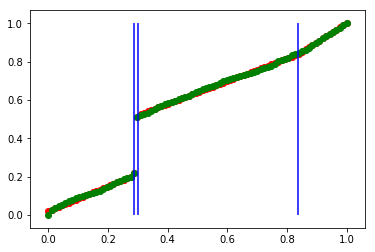

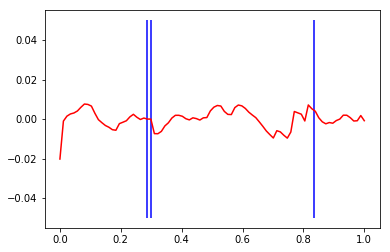

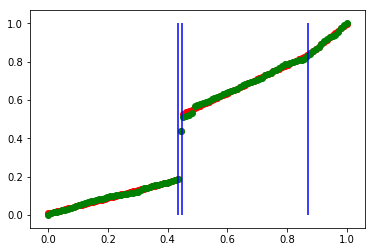

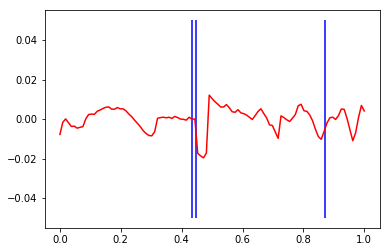

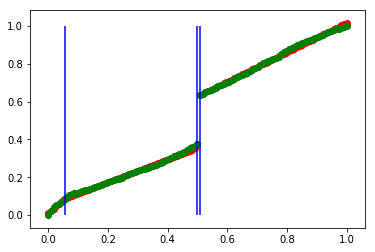

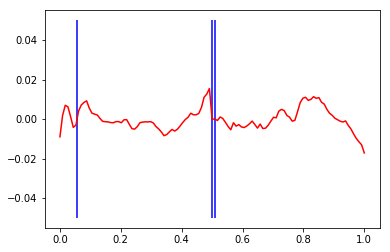

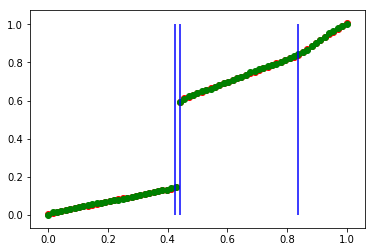

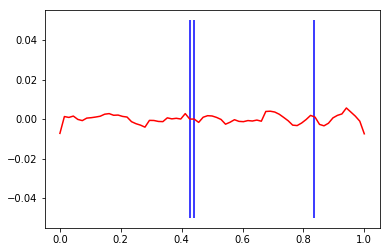

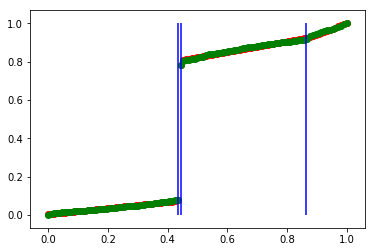

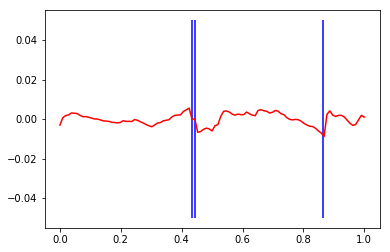

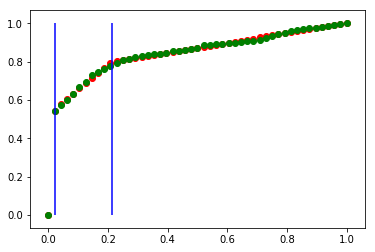

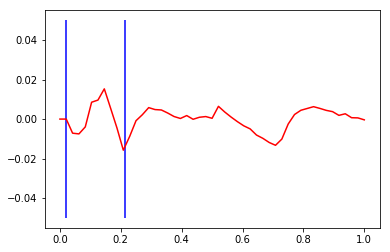

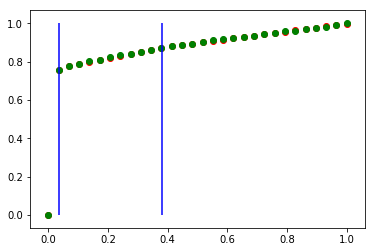

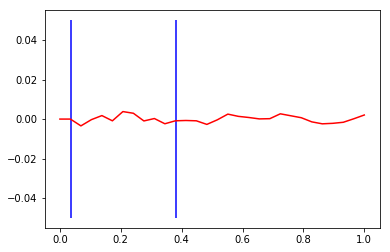

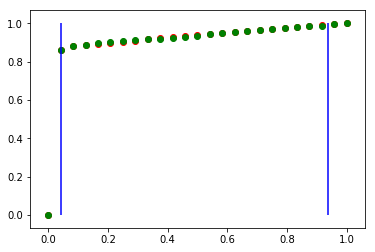

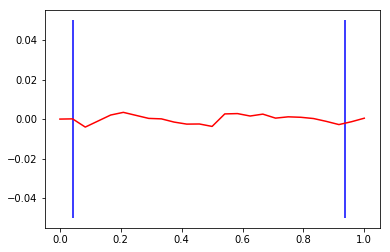

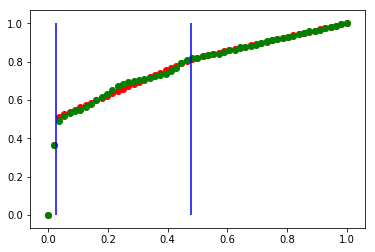

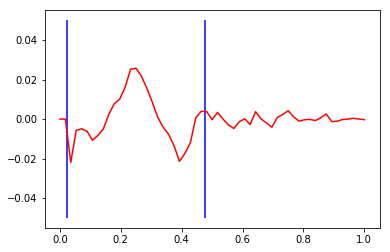

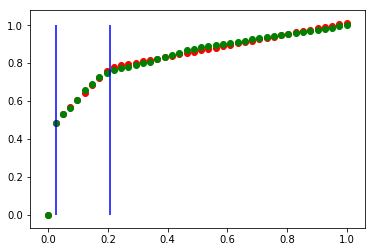

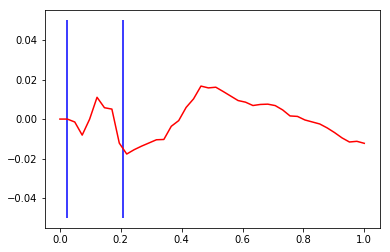

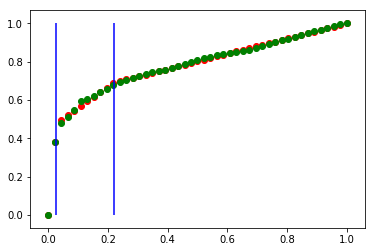

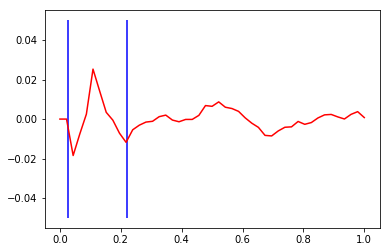

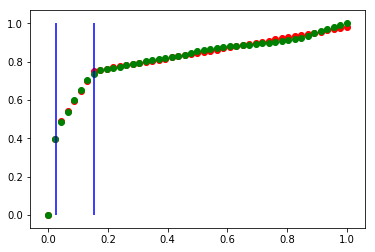

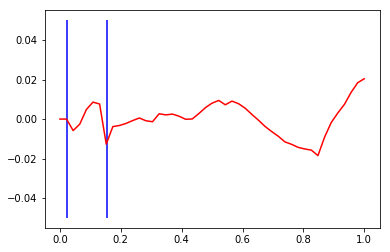

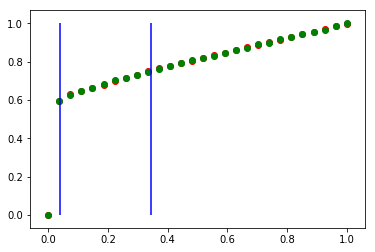

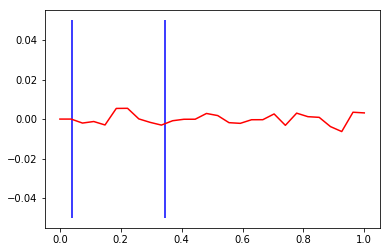

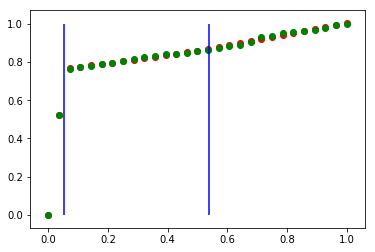

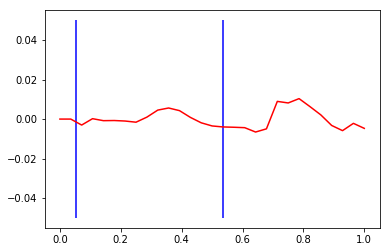

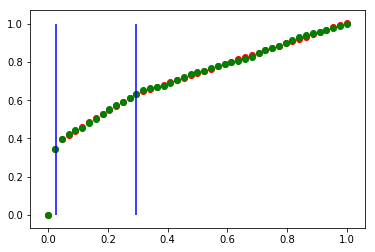

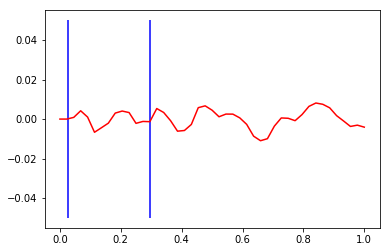

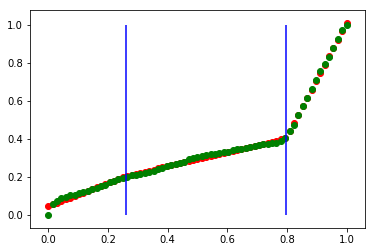

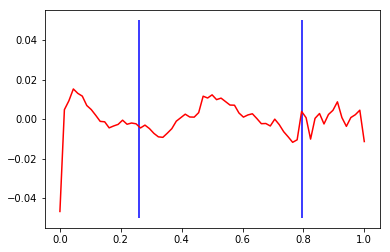

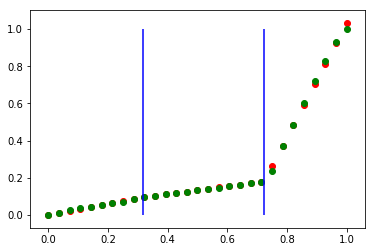

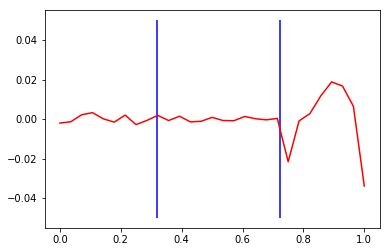

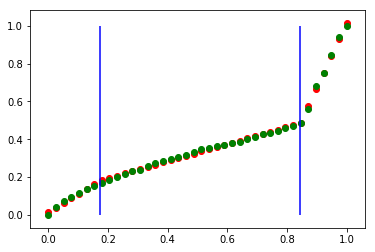

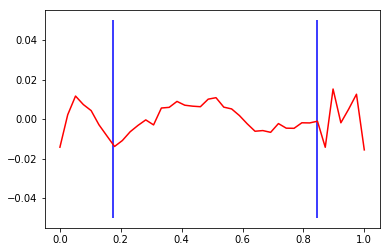

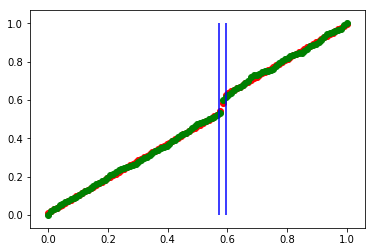

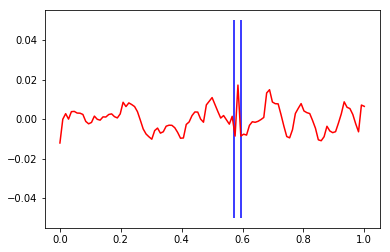

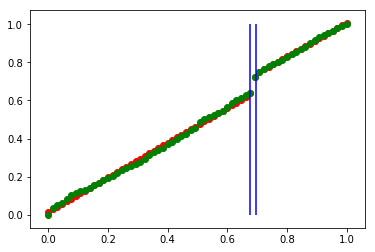

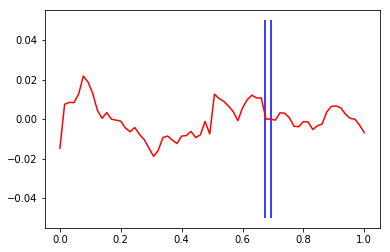

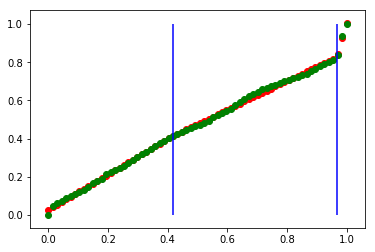

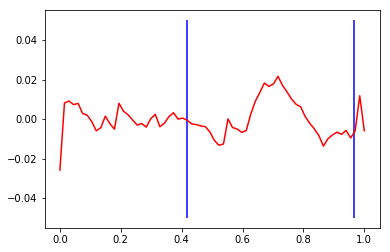

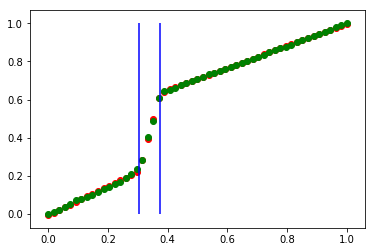

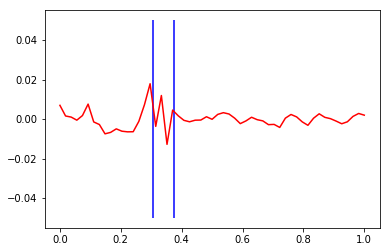

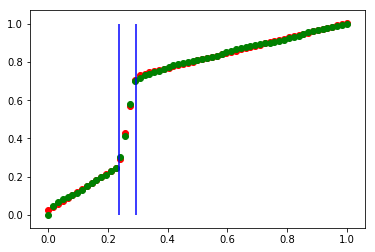

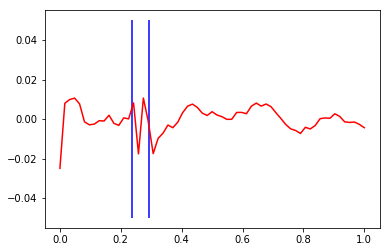

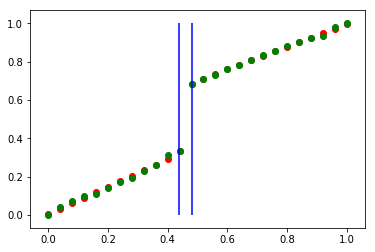

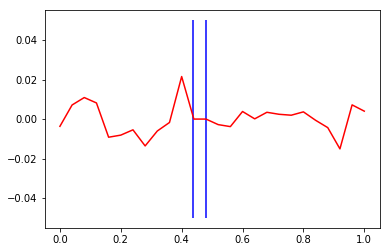

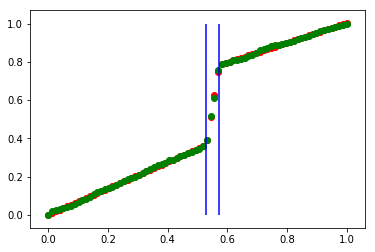

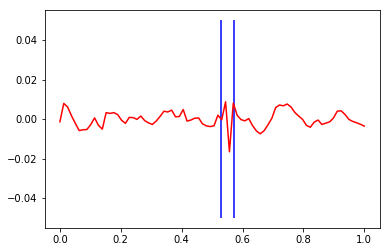

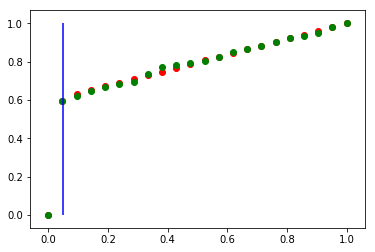

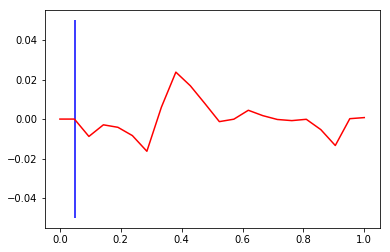

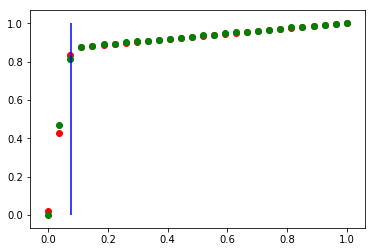

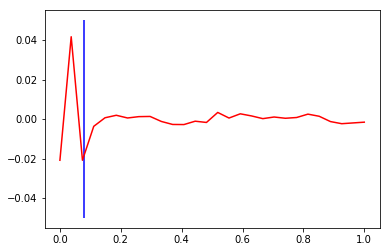

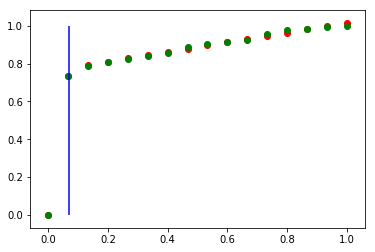

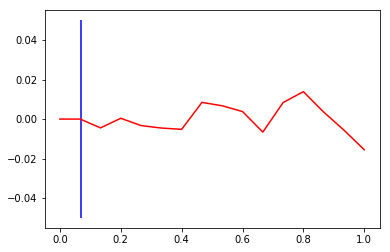

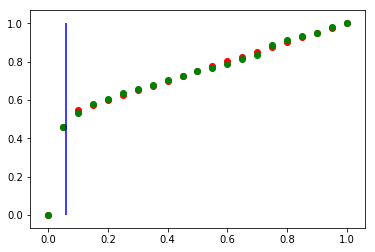

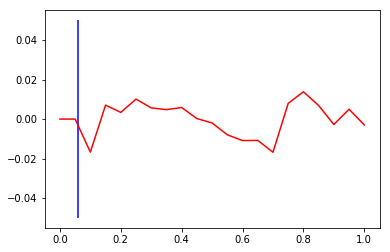

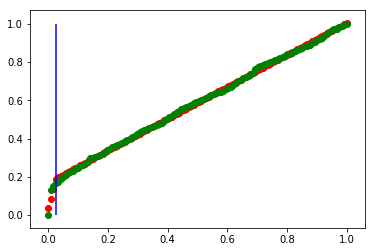

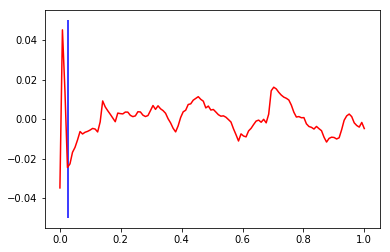

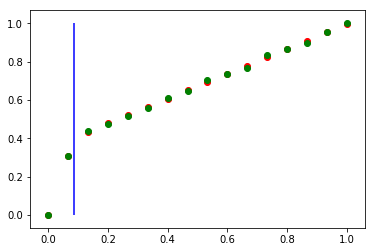

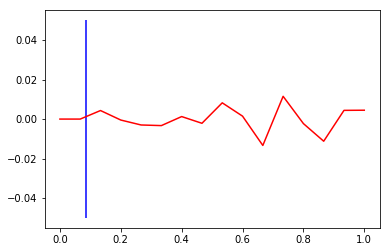

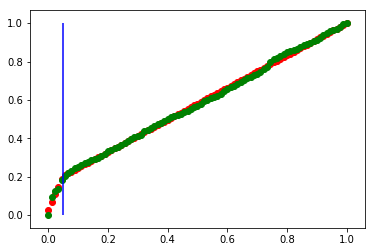

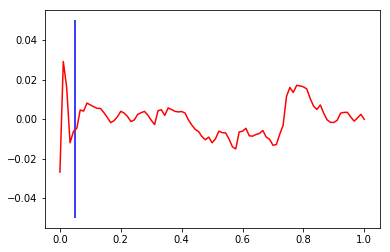

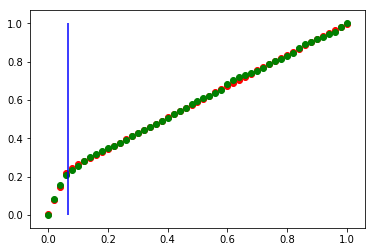

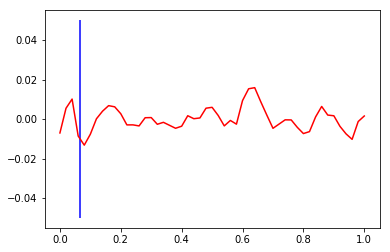

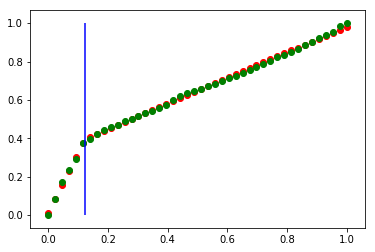

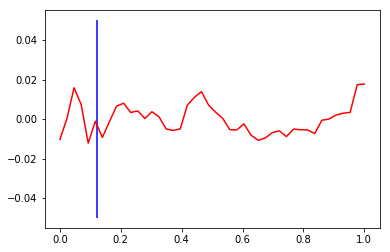

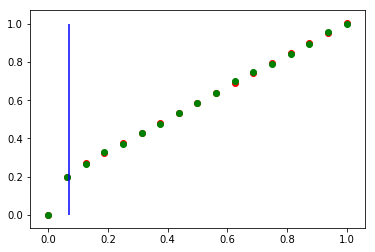

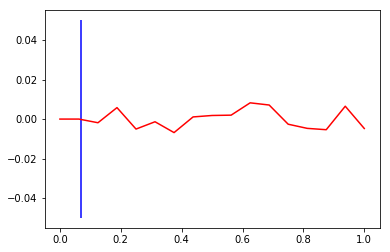

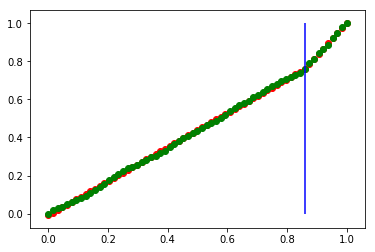

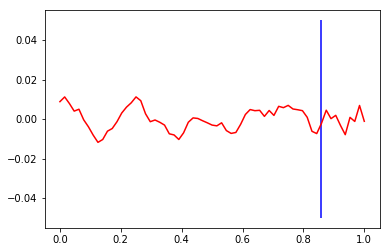

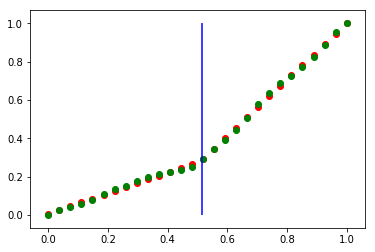

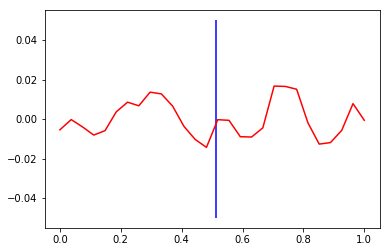

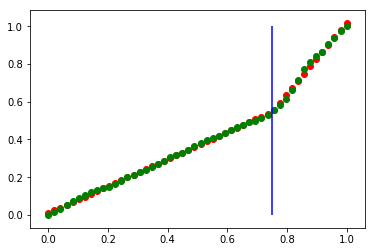

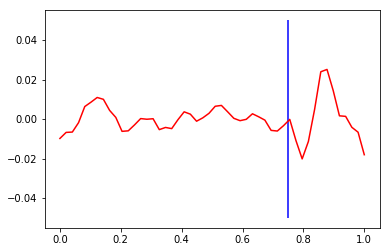

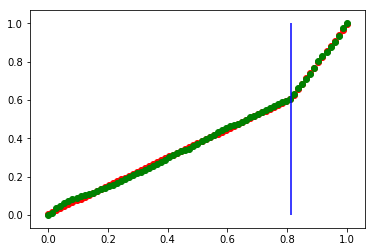

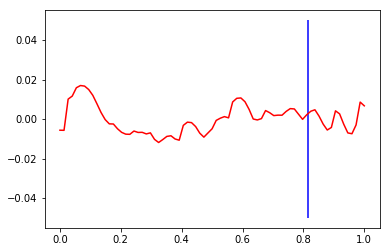

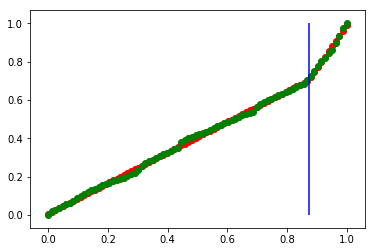

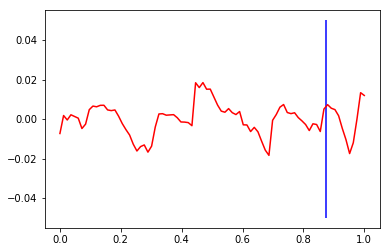

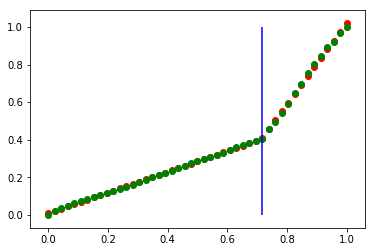

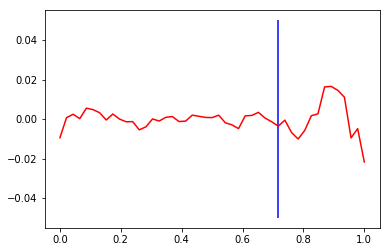

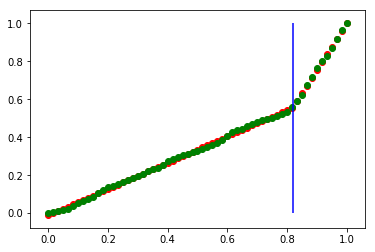

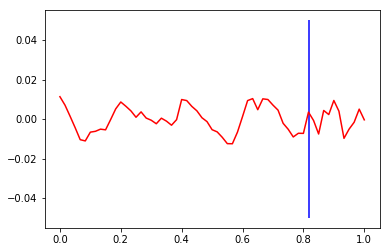

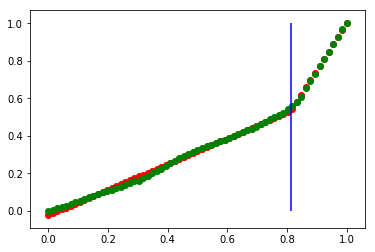

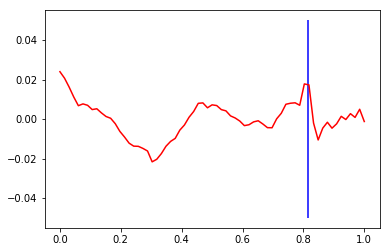

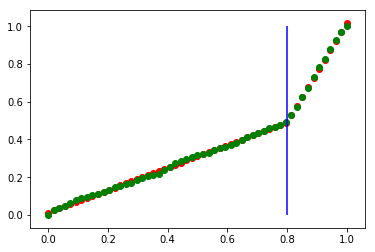

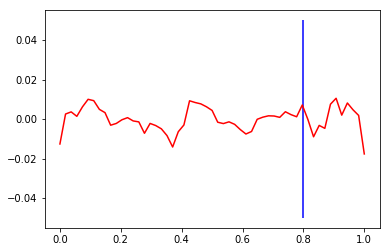

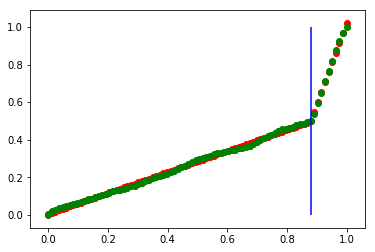

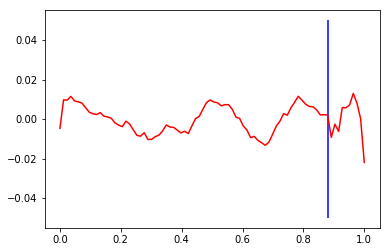

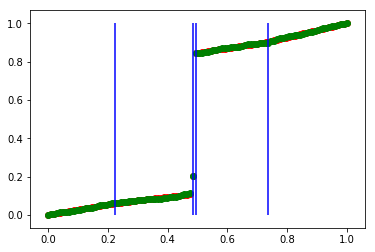

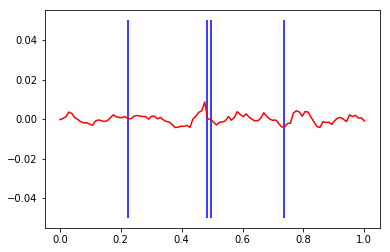

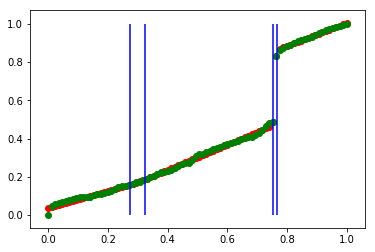

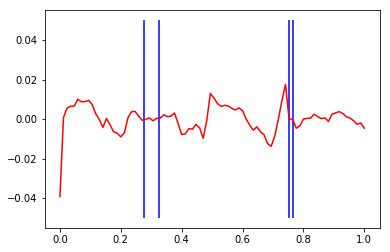

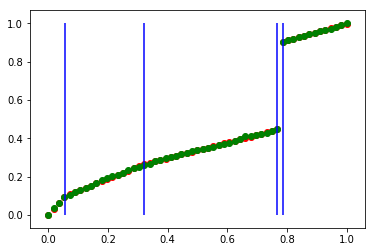

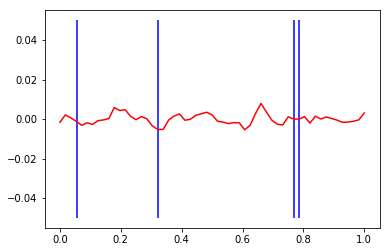

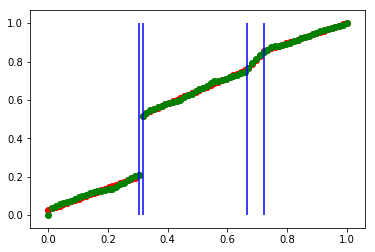

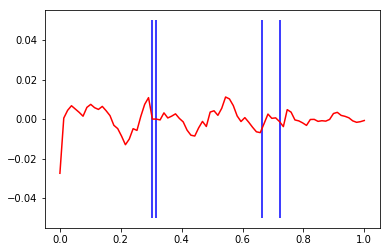

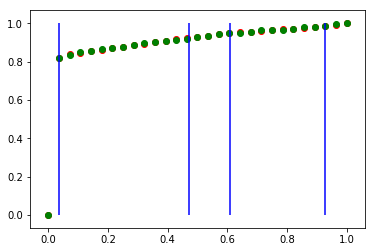

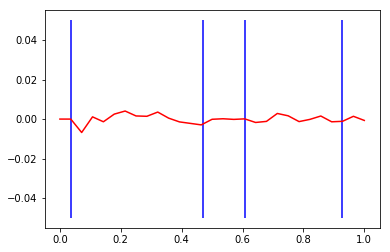

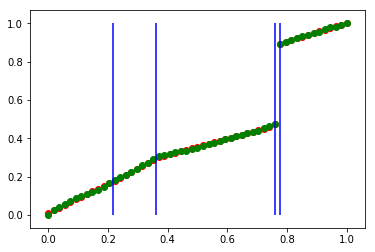

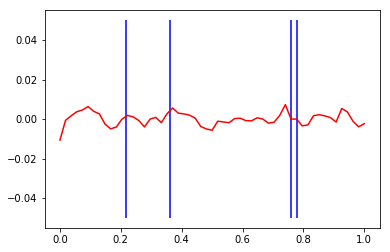

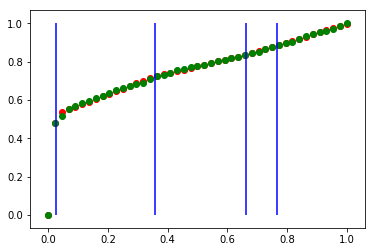

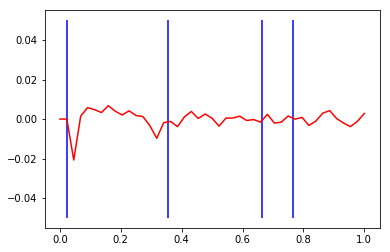

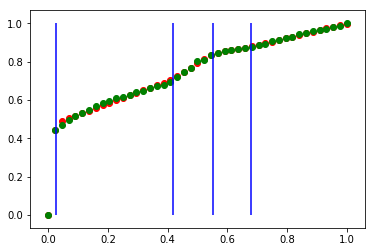

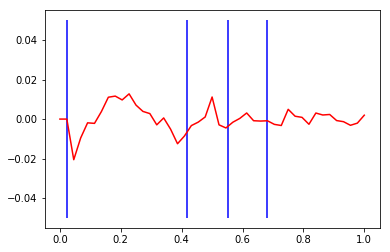

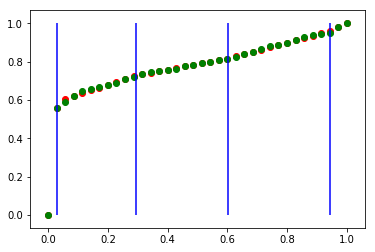

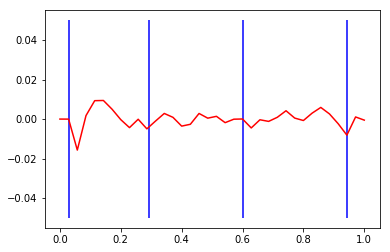

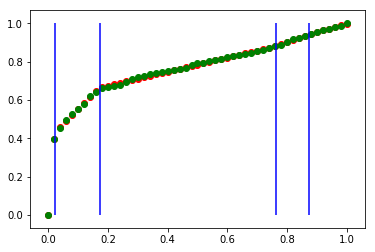

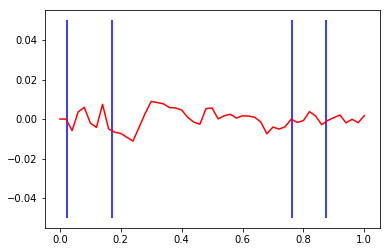

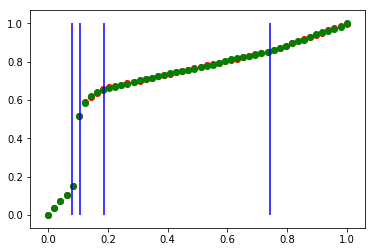

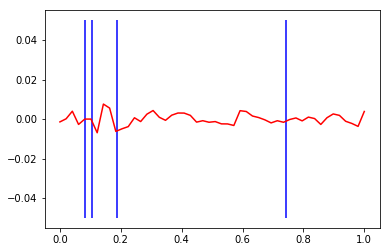

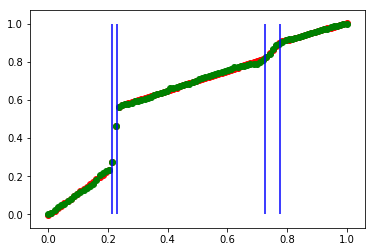

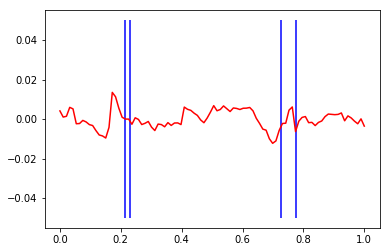

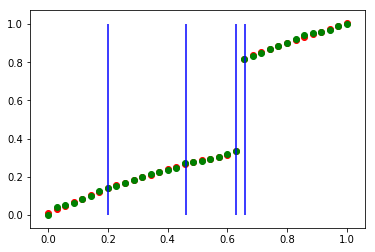

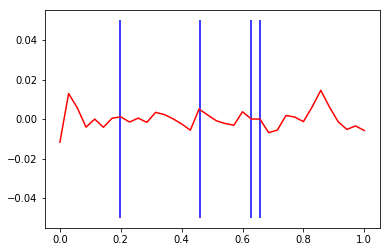

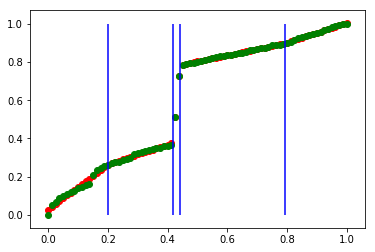

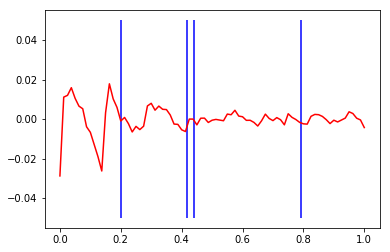

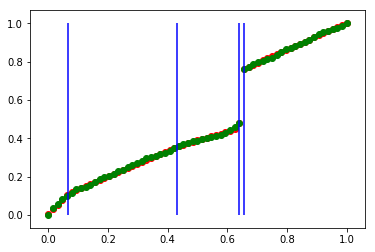

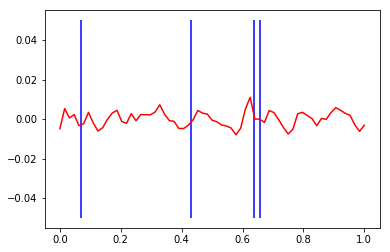

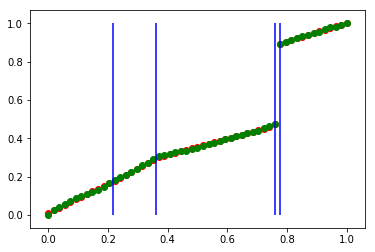

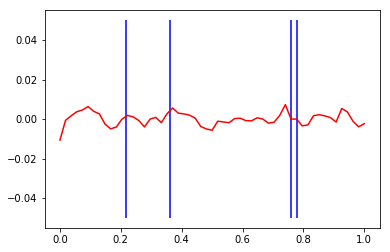

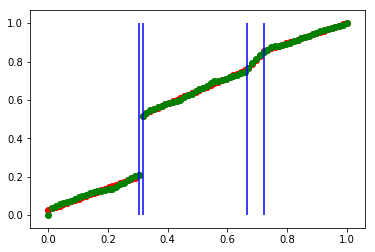

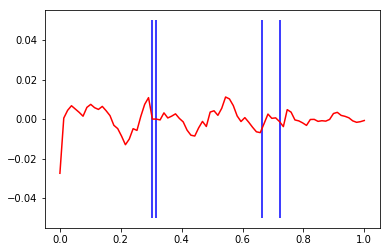

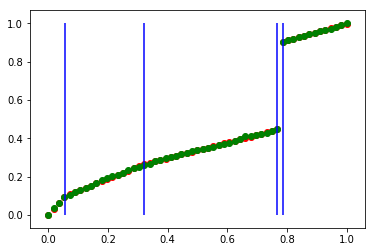

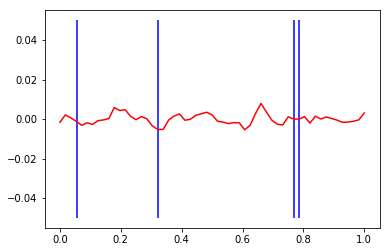

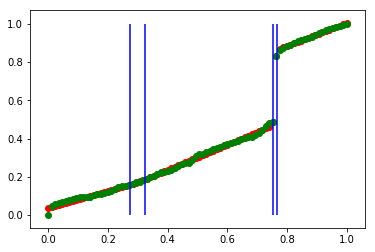

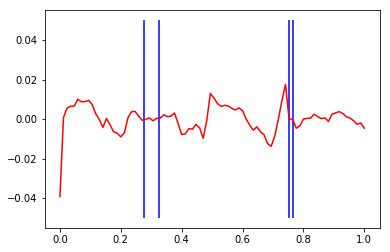

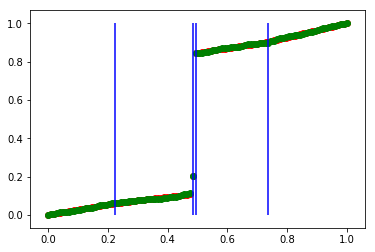

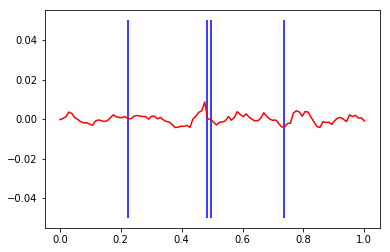

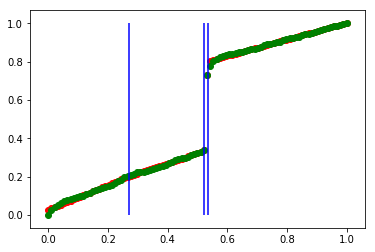

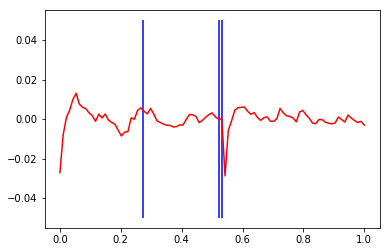

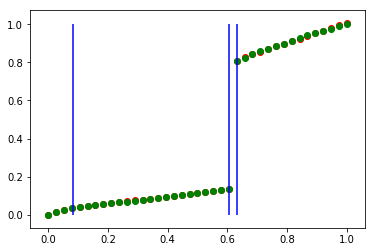

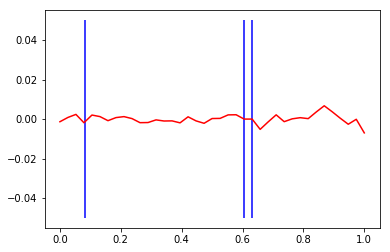

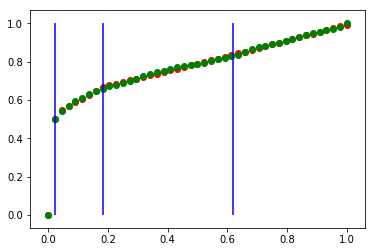

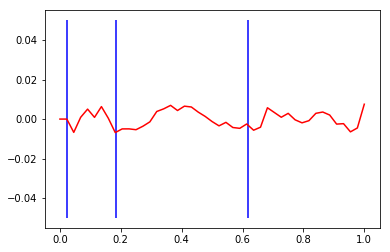

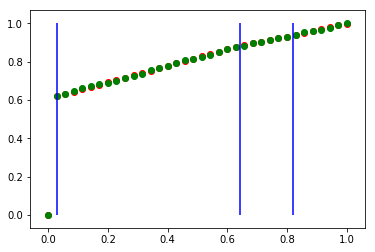

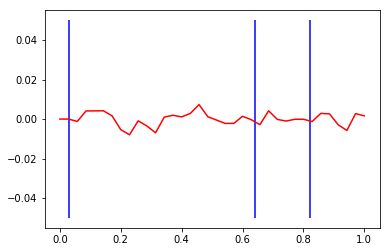

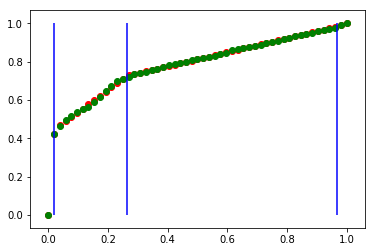

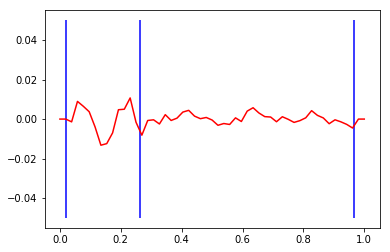

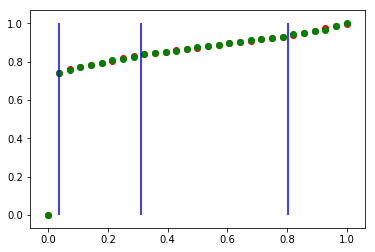

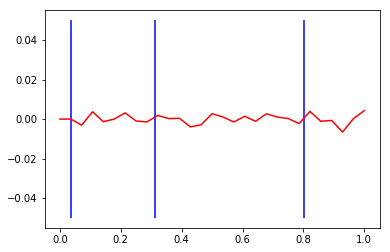

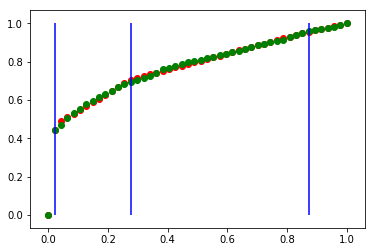

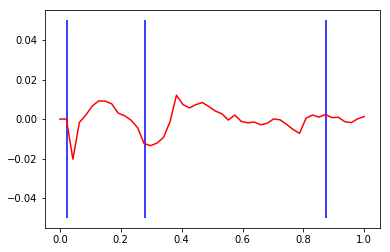

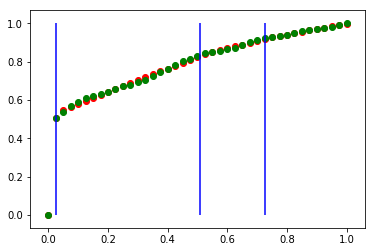

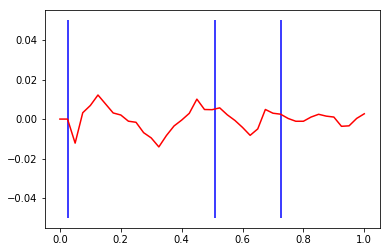

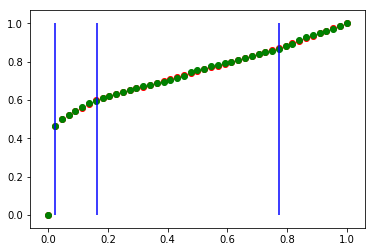

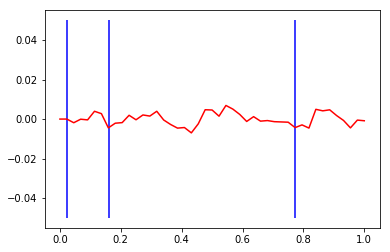

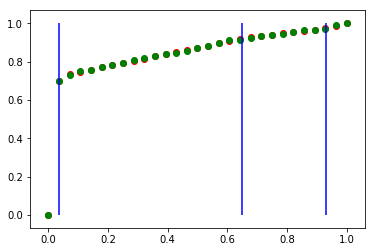

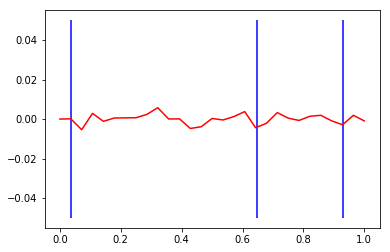

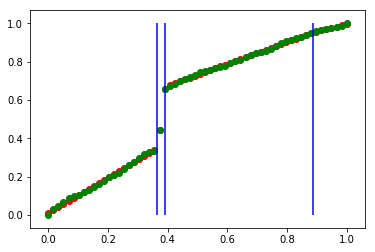

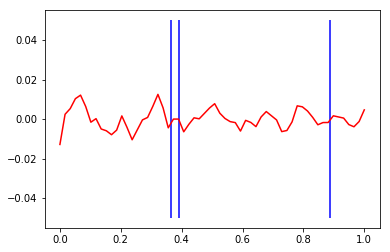

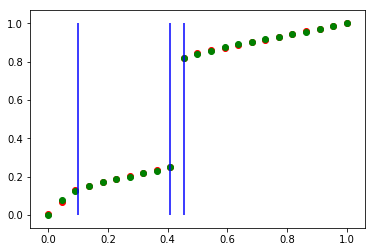

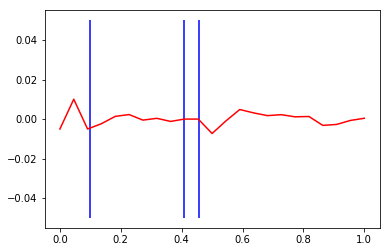

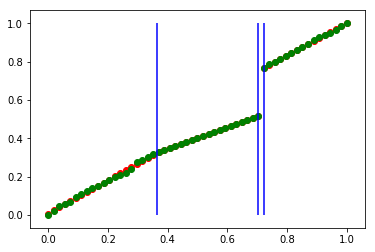

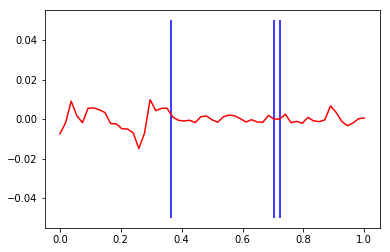

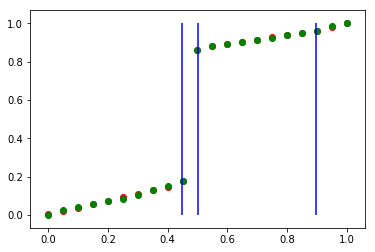

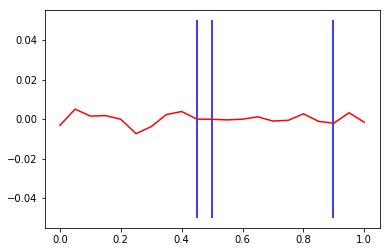

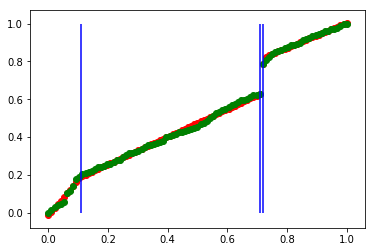

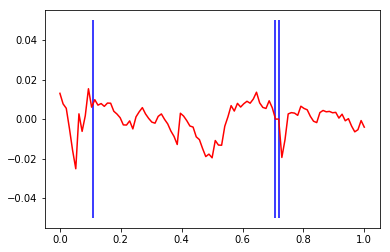

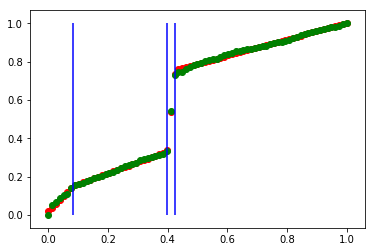

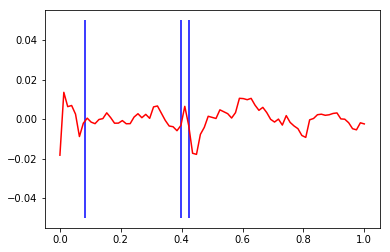

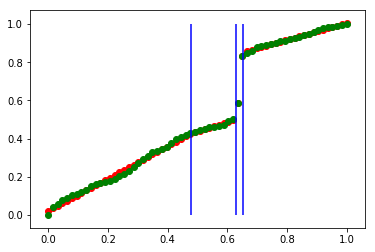

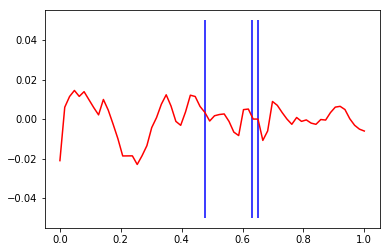

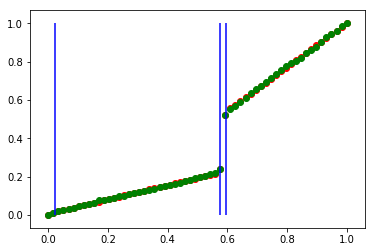

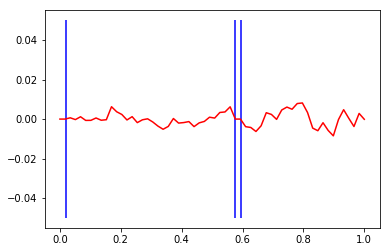

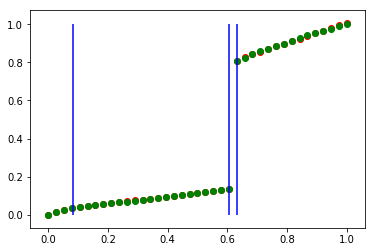

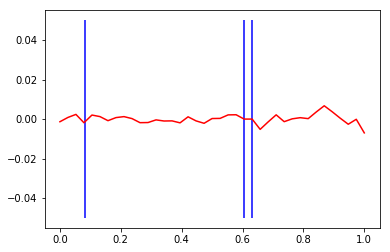

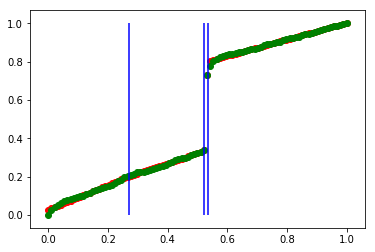

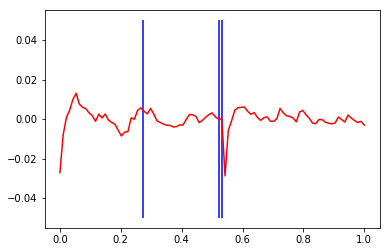

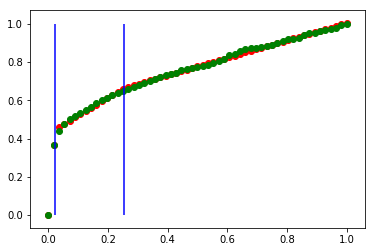

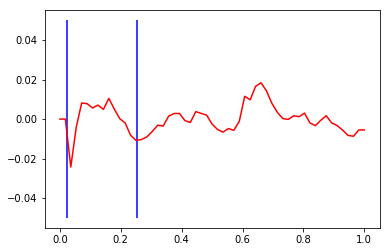

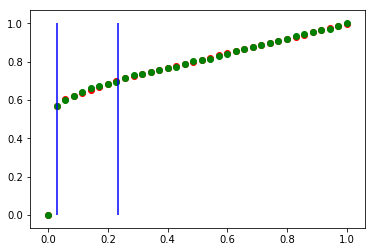

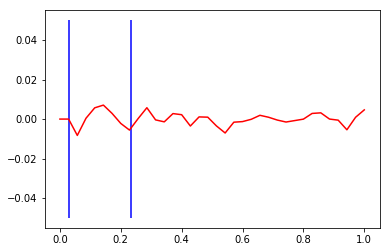

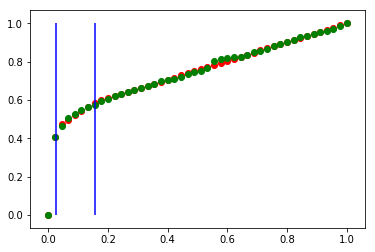

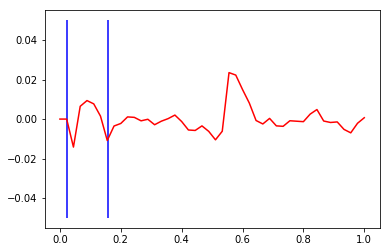

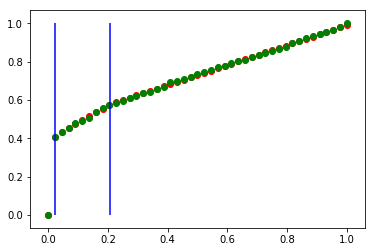

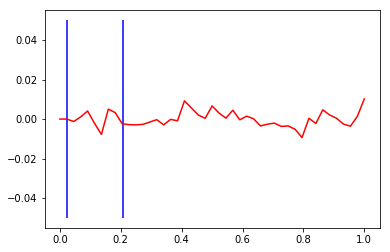

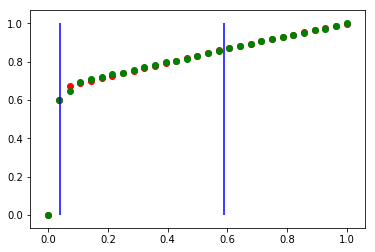

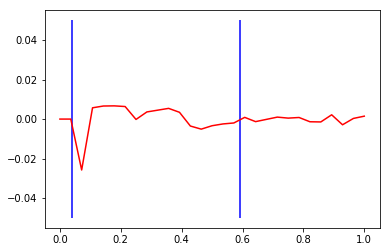

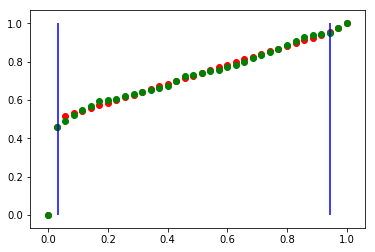

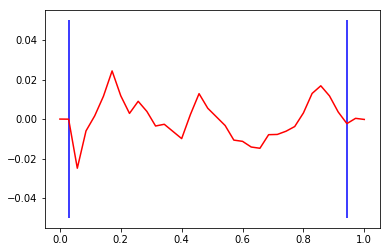

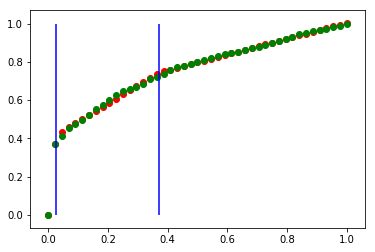

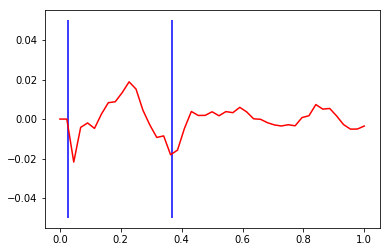

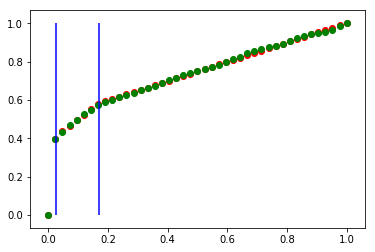

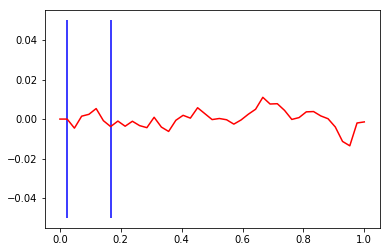

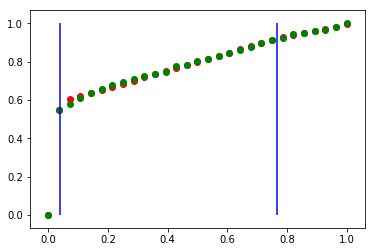

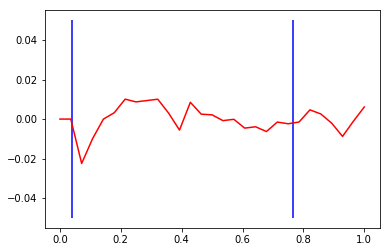

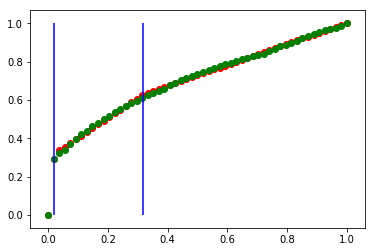

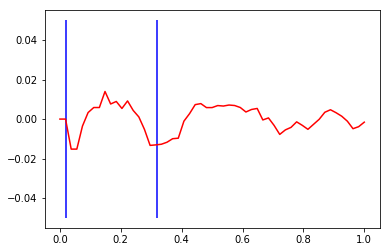

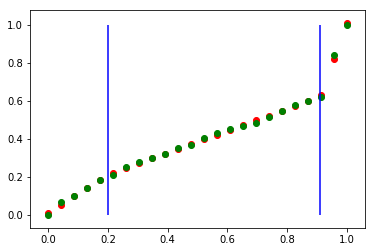

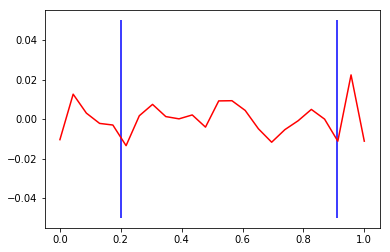

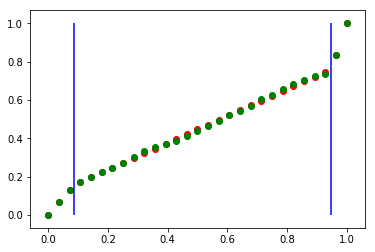

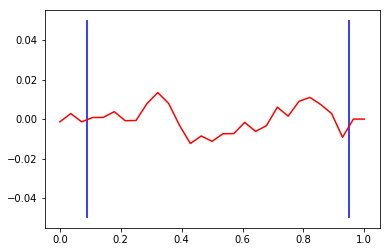

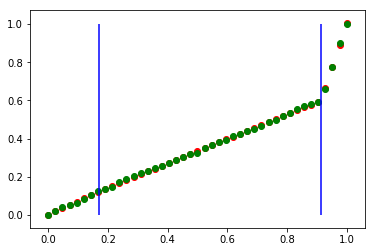

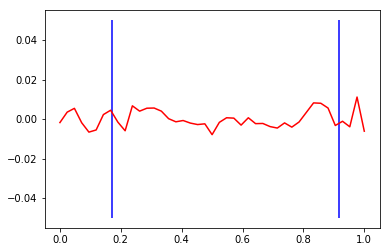

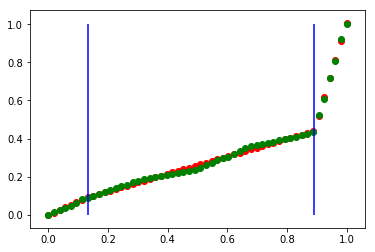

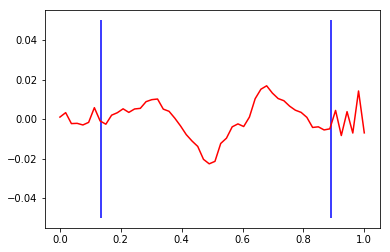

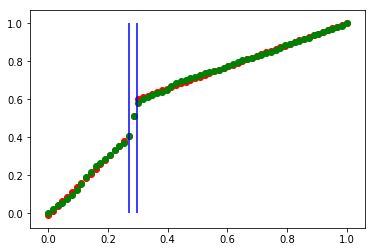

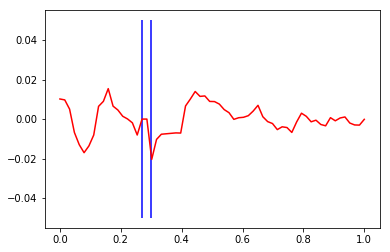

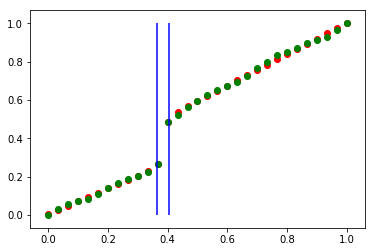

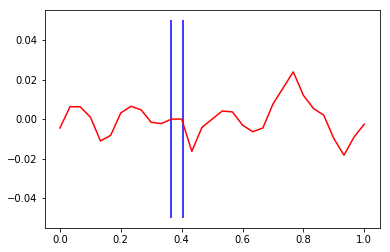

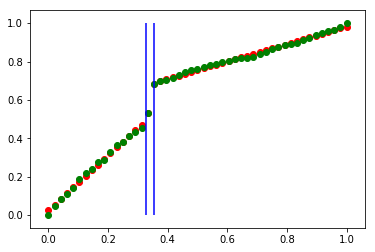

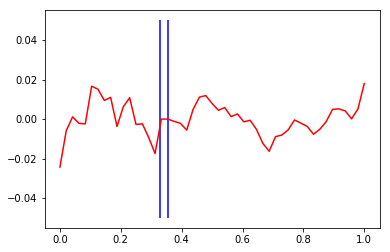

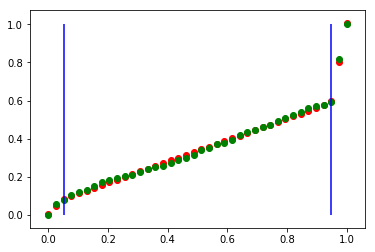

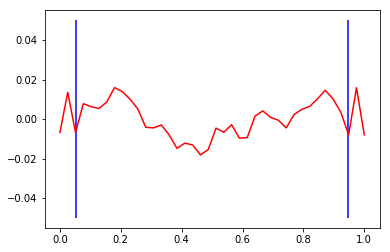

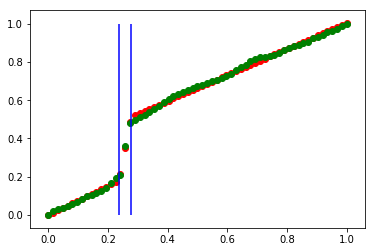

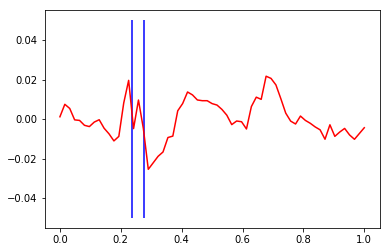

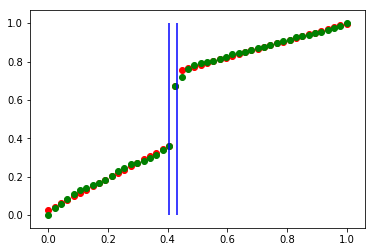

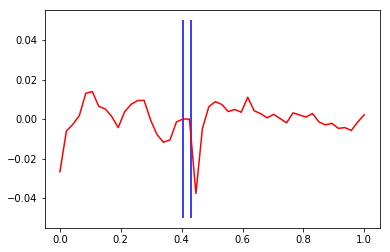

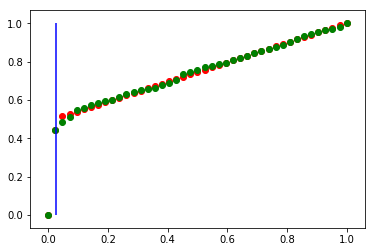

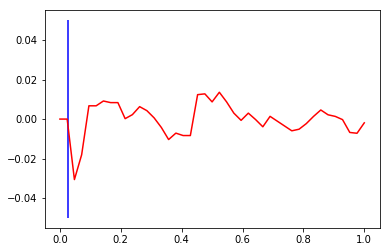

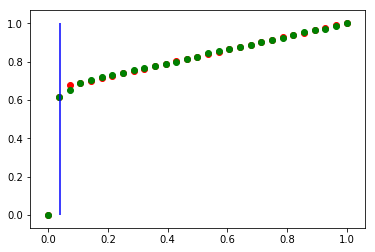

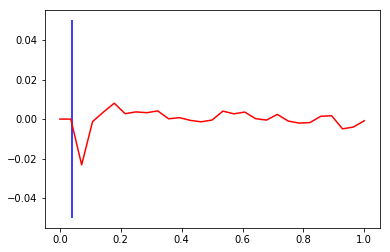

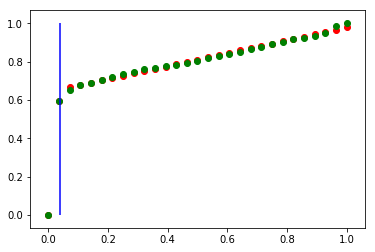

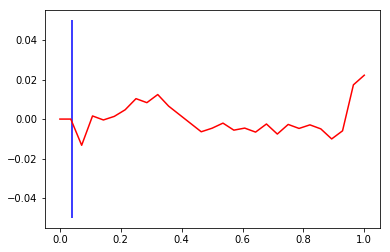

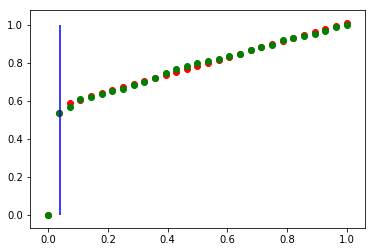

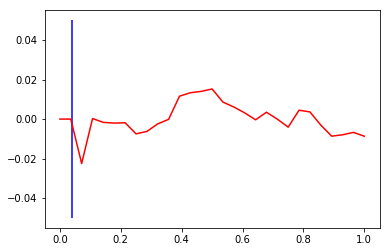

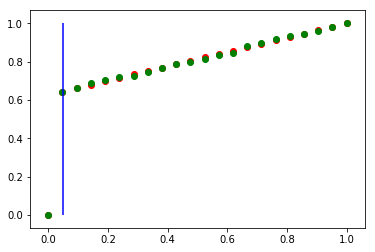

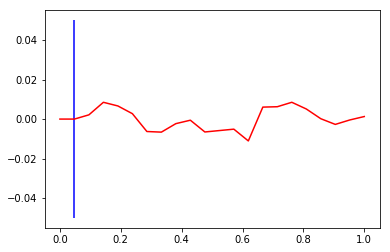

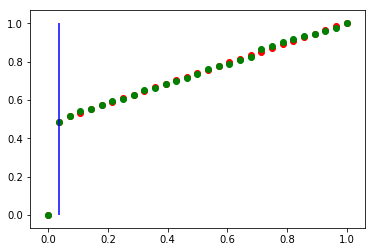

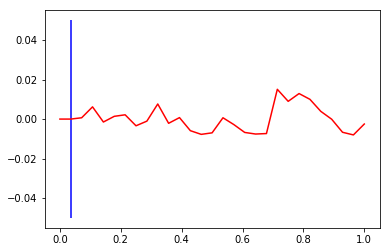

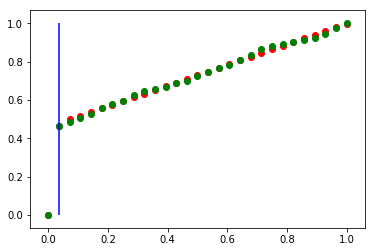

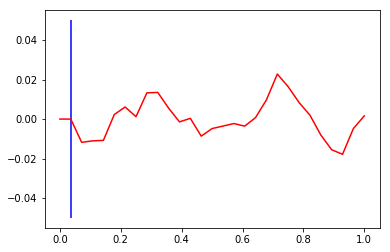

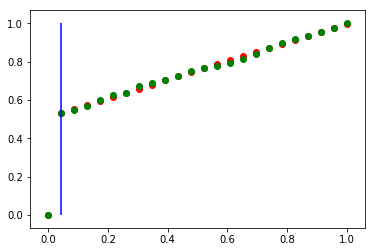

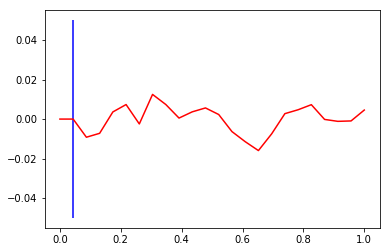

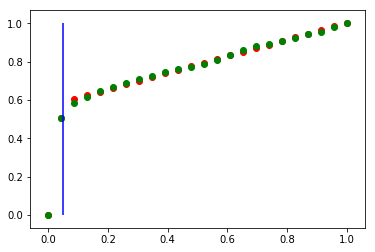

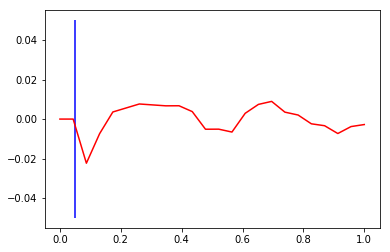

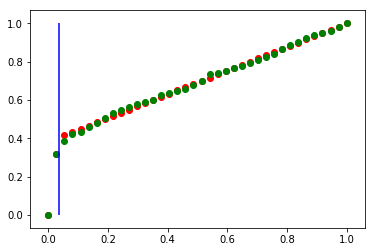

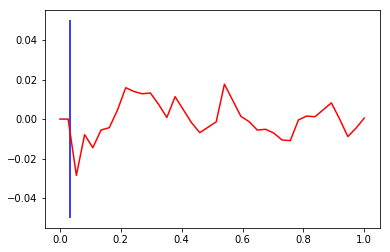

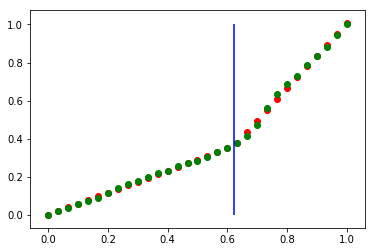

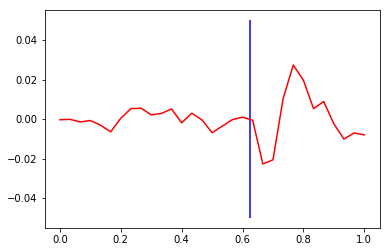

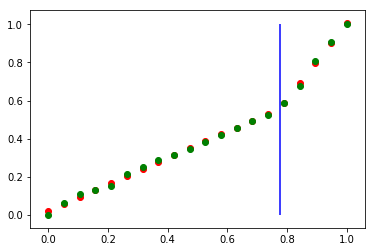

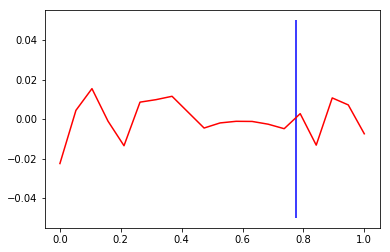

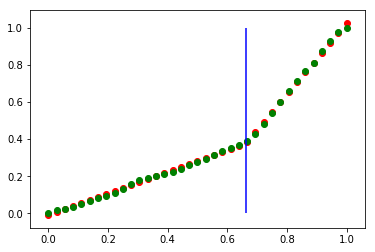

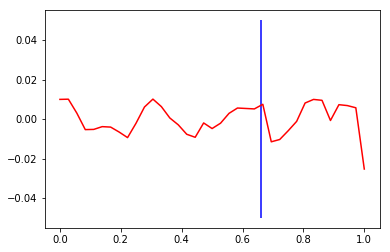

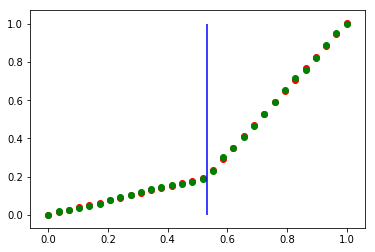

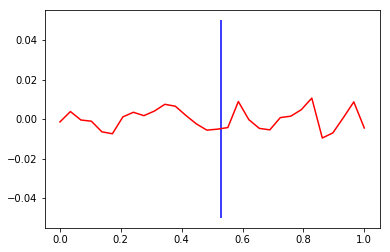

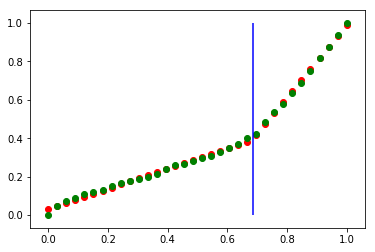

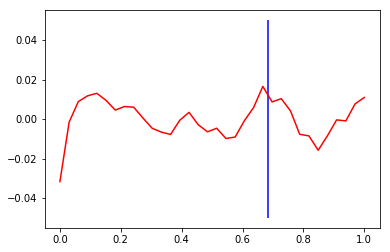

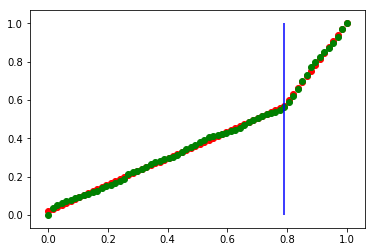

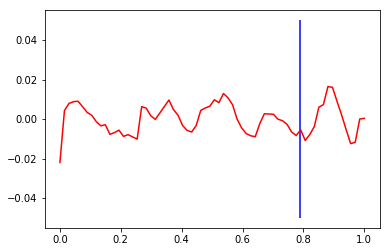

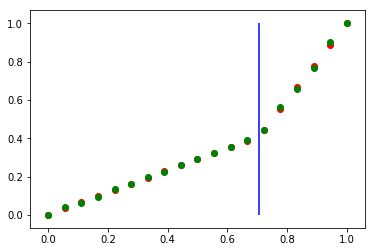

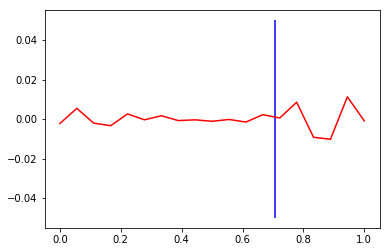

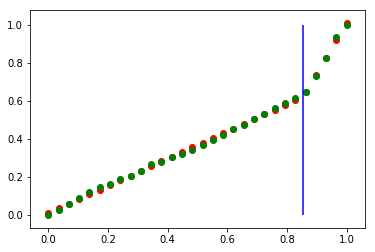

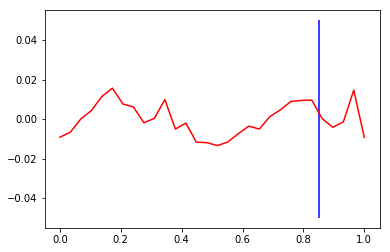

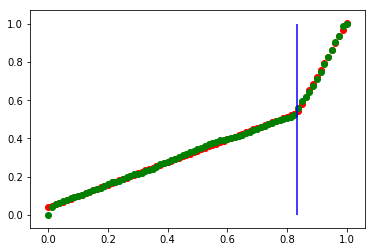

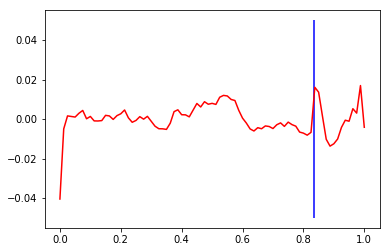

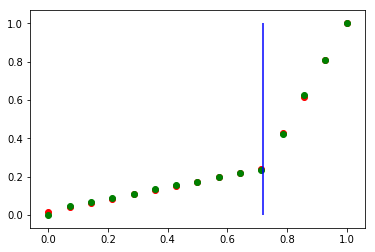

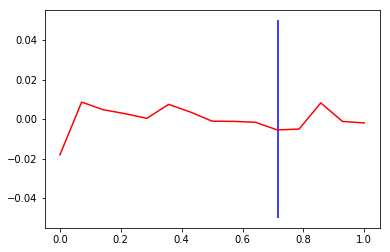

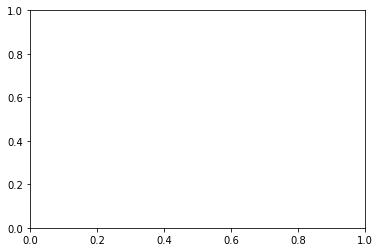

In [34]:
for k,idxs in groups.items():
    head = 'group'+str(k)
    deltas_std = defaultdict(lambda:[]) 
    groupby_number_intervals = get_by_intervals(data,idxs)
    for number_of_intervals,valid_idxs in groupby_number_intervals.items():
        ranking = brusque_changes(get_value(data,0,valid_idxs),10)
        for r in ranking:
            sample = data[r]
            x = norm(sample[2])
            y = norm(sample[3])
            y_pred = sample[-1]
            bpoints = sample[1]
            slopes = sample[0]
            
            plot(x,y_pred,'red')
            plot(x,y,'green')
            plt.vlines(bpoints,ymin=0,ymax=1,color='blue')
            plt.savefig('imgs_python/preds/'+head+'/original_pred_'+str(number_of_intervals)+'_'+str(r)+'.png')
            plt.show()
            plt.cla()
            
            plt.vlines(bpoints,ymin=-0.05,ymax=0.05,color='blue')
            plt.plot(x,y-y_pred,color='red')
            plt.savefig('imgs_python/preds/'+head+'/original_pred_'+str(number_of_intervals)+'_'+str(r)+'_diff.png')
            plt.show()
            plt.cla()

In [29]:
def hist_delta_std(window_value,get_values):
    count = 0
    deltas_std = defaultdict(lambda:[]) 
    deltas_points = defaultdict(lambda:[])
    for k,idxs in groups.items():
        head = 'group'+str(k)
#         groupby_number_intervals = get_by_intervals(data,idxs)
#         for number_of_intervals,valid_idxs in groupby_number_intervals.items():
#             for idx in valid_idxs:
        for idx in idxs:
            sample = data[idx]
            x = norm(sample[2])
            y = norm(sample[3])
            y_pred = sample[-1]
            bpoints = sample[1]
            slopes = sample[0]

            for i,b in enumerate(bpoints):
                vs = get_values(x,y,b,window_value)
                std = np.std(vs)
                slope_diff = slopes[i+1]-slopes[i]
                count += 1
                key = 1 if slope_diff > 0 else -1
                deltas_std[key].append(std)
                deltas_points[key].append(vs)
#     print(count)
    return deltas_std,deltas_points

In [30]:
def hists(delta,get_values):
    deltas_std,deltas_points = hist_delta_std(delta,get_values)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3),sharey=True)
    curve_pos_std = np.nanmean(deltas_std[1])
    ax1.hist(deltas_std[1], 10, density=True, facecolor='g', alpha=0.75, range=(0,0.1))
    ax1.set_title('Curve (positive) std mean = %.4f '% curve_pos_std)
    
    curve_neg_std = np.nanmean(deltas_std[-1])
    ax2.hist(deltas_std[-1], 10, density=True, facecolor='g', alpha=0.75,range=(0,0.1))
    ax2.set_title('Curve (negative) std mean = %.4f '% curve_neg_std)
    fig.show()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3),sharey=True)
    ys1 = np.nanmean(deltas_points[1],axis=0)
#     print('ys1',ys1)
#     print('min',np.nanmin(deltas_points[1],axis=0),'max',np.nanmax(deltas_points[1],axis=0))
    xs = list(range(len(ys1)))
    ax1.plot(xs,ys1)
    ax1.scatter(xs,ys1)
    ax1.set_title('Curve (positive)')
    
    ys2 = np.nanmean(deltas_points[-1],axis=0)
#     print(deltas_points[-1][:10])
#     print(deltas_points[-1][-10:])
#     print('ys2',ys2)
#     print('min',np.nanmin(deltas_points[-1],axis=0),'max',np.nanmax(deltas_points[-1],axis=0))
    xs = list(range(len(ys2)))
    ax2.plot(xs,ys2)
    ax2.scatter(xs,ys2)
    ax2.set_title('Curve (negative)')
    fig.show()

In [ ]:
hists(0.01,get_values_window) # não funciona

In [ ]:
hists(0.02,get_values_window)

In [ ]:
hists(0.03,get_values_window)

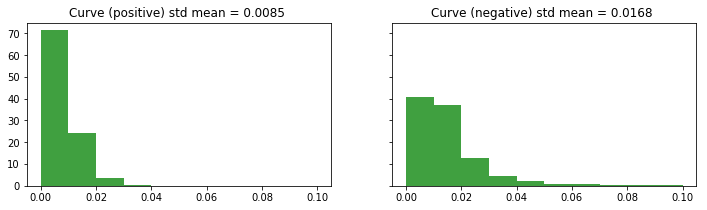

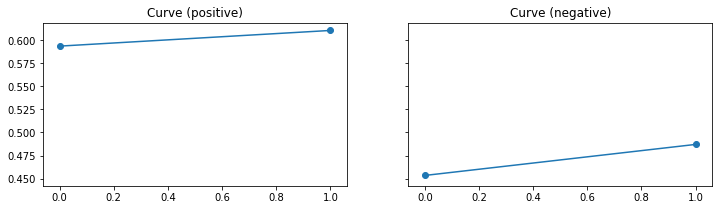

In [31]:
hists(1,get_values_points)

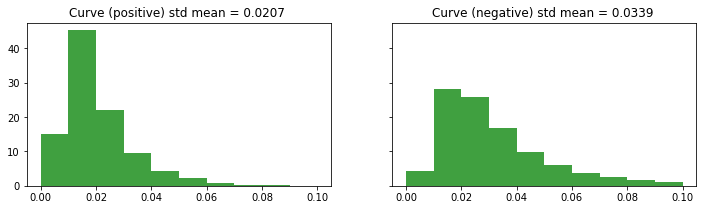

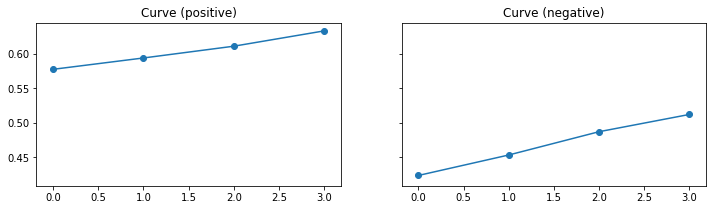

In [32]:
hists(2,get_values_points)

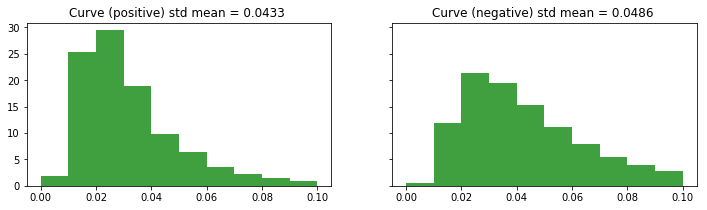

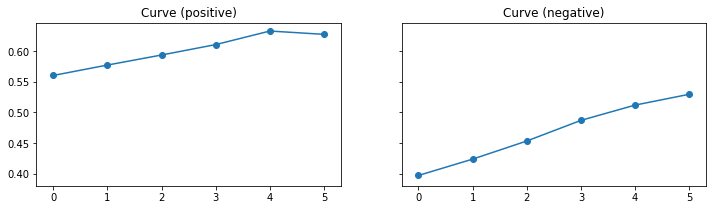

In [33]:
hists(3,get_values_points)

In [ ]:
# janela de pontos vs a curva (se está captando a diferença)